# Project: R2 - RAGAS (Retrieval-Augmented Generation for Answer Selection) Evaluation

Ad Soyad: Önder Görmez  
Öğrenci No: 21501035


# RAGAS Evaluation

RAGAS (Retrieval-Augmented Generation for Answer Selection) is an evaluation framework designed to assess the performance of retrieval-augmented generation models. These models combine information retrieval techniques with generative models to produce more accurate and contextually relevant answers to queries.

## Key Components of RAGAS Evaluation

1. **Retrieval Component**:

   - The retrieval component is responsible for fetching relevant documents or passages from a large corpus based on the input query.
   - The quality of the retrieval component is evaluated based on metrics such as precision, recall, and F1-score, which measure how well the retrieved documents match the relevant documents.

2. **Generation Component**:

   - The generation component uses the retrieved documents to generate a coherent and contextually appropriate answer to the query.
   - The quality of the generation component is evaluated based on metrics such as BLEU, ROUGE, and METEOR, which measure the similarity between the generated answer and the reference answer.

3. **Combined Evaluation**:
   - RAGAS evaluates the combined performance of the retrieval and generation components.
   - This involves assessing how well the retrieved documents support the generation of accurate and relevant answers.
   - Metrics such as Exact Match (EM) and F1-score are used to evaluate the overall performance of the system.

## Evaluation Metrics

- **Precision**: Measures the proportion of relevant documents among the retrieved documents.
- **Recall**: Measures the proportion of relevant documents that were retrieved from the total relevant documents.
- **F1-Score**: The harmonic mean of precision and recall, providing a single metric that balances both.
- **BLEU (Bilingual Evaluation Understudy)**: Measures the n-gram overlap between the generated answer and the reference answer.
- **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**: Measures the overlap of n-grams, word sequences, and word pairs between the generated answer and the reference answer.
- **METEOR (Metric for Evaluation of Translation with Explicit ORdering)**: Considers synonyms, stemming, and paraphrasing in addition to n-gram overlap.
- **Exact Match (EM)**: Measures the percentage of generated answers that exactly match the reference answers.
- **Combined F1-Score**: Evaluates the overall performance by considering both retrieval and generation quality.

## Example Workflow

1. **Query Input**: A user inputs a query.
2. **Document Retrieval**: The retrieval component fetches relevant documents from a corpus.
3. **Answer Generation**: The generation component uses the retrieved documents to generate an answer.
4. **Evaluation**: The generated answer is compared to the reference answer using the evaluation metrics.

## Conclusion

RAGAS evaluation provides a comprehensive framework for assessing the performance of retrieval-augmented generation models. By combining retrieval and generation metrics, it ensures that the models are evaluated holistically, considering both the relevance of the retrieved documents and the quality of the generated answers. This approach helps in developing more effective and accurate models for tasks such as question answering and information retrieval.


# Colab İle Çalışmanın Ayarlanması

Colab üzerinde çalışırken, bazı directory lerin değiştirilmesi ve bunlar üzerinde kodun çalıştırılması gerekmektedir. Aşağıdaki şekilde yapılır.


In [12]:
import os

PROJECT_DIR = ''

IS_GOOGLE_COLAB_ENABLED = False

if IS_GOOGLE_COLAB_ENABLED:
    print('Google Colab is enabled. Running on Google Colab.')

    from google.colab import drive
    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)

    PROJECT_DIR = '/content/drive/MyDrive/Colab/'

    # Ensure the directory exists
    os.makedirs(PROJECT_DIR, exist_ok=True)

else:
    print('Google Colab is not enabled. Running locally.')

    # Local configuration and folder setup
    PROJECT_DIR = '/Users/ondergormez/Repos/BLM5109_Collective_Learning/03-Project/'

LLM_ANSWERS_DIR = PROJECT_DIR + 'llm_answers'
RAGAS_SCORES_DIR = PROJECT_DIR + 'ragas_scores'

# Ensure the directory exists
os.makedirs(LLM_ANSWERS_DIR, exist_ok=True)
os.makedirs(RAGAS_SCORES_DIR, exist_ok=True)

Google Colab is not enabled. Running locally.


# Logger Kullanımı

- Oluşturulan kod içerisinde loglama işlemleri için `logging` kütüphanesi kullanılmıştır.
- Böylelikle geliştirme aşamasında debug için koyulan kodların çıktılarına bakılarak hata ayıklama işlemleri yapılabilir. Bu kodların çıktıları rapor sunulurken kaldırılacaktır.


In [13]:
import logging
import logging.config
import yaml
import textwrap


class CustomFormatter(logging.Formatter):

    def format(self, record):
        wrapped_message = super().format(record)

        # wrap the log messages to 120 characters to better fit the screen
        if (len(wrapped_message) > 120):
            wrapped_message = "\n".join(textwrap.wrap(wrapped_message, width=120))

            # indent the wrapped lines but not the first line
            first_line, rest = wrapped_message.split('\n', 1)
            wrapped_message = first_line + '\n' + textwrap.indent(rest, ' ' * 4) + '\n'

        return wrapped_message


LOGGER_CONFIG_FILE = PROJECT_DIR + 'logger_config.yaml'

# Load the YAML configuration
with open(LOGGER_CONFIG_FILE, 'r') as file:
    config = yaml.safe_load(file.read())
    logging.config.dictConfig(config)

# Apply the custom formatter to the selected handler
logger = logging.getLogger("default_logger")
for handler in logger.handlers:
    if isinstance(handler, logging.StreamHandler):
        handler.setFormatter(CustomFormatter(handler.formatter._fmt, datefmt=handler.formatter.datefmt))

# TODO: Set the log level to INFO
# logger.setLevel(logging.DEBUG)
logger.setLevel(logging.INFO)


logger.debug("This is a debug message that will be wrapped after 140 characters. " * 10)
logger.info("Logging is configured successfully.")

[INFO] [2025-01-28T09:30:33.886Z] Logging is configured successfully.


# Çalıştırılmayacak Kodlar

- Bazı kodların geçici olarak tutulması falan çalıştırılmaması gerekebilir.
- Bunun için aşağıdaki gibi bir işlem yapılabilir.


In [3]:
from IPython.core.magic import register_cell_magic


@register_cell_magic
def skip(line, cell):
    logger.info(f"TODO: Bu hücre çalıştırılmayacak!")
    logger.info(f" Extra comment: {line}")
    pass

In [ ]:
%%skip TODO: Bu hücre kullanılmıyorsa silinebilibir.
logger.info("Hello world!")

# Dataset'in Yüklenmesi

https://huggingface.co/datasets/Metin/WikiRAG-TR adresinde bulunan dosyadaki bilgileri kullanacağız. Bunun için dataseti parquet formatında indirip, yükledik.

- https://huggingface.co/datasets/Metin/WikiRAG-TR/tree/refs%2Fconvert%2Fparquet/default/train
- [Download 0000.parquet](https://huggingface.co/datasets/Metin/WikiRAG-TR/resolve/refs%2Fconvert%2Fparquet/default/train/0000.parquet?download=true)


In [ ]:
import pandas as pd

FILE_PATH = PROJECT_DIR + '0000.parquet'

# Read the Parquet file into a DataFrame
raw_data_df = pd.read_parquet(FILE_PATH)

logger.info("Columns of the raw dataframe: " + str(raw_data_df.columns))

logger.info("Shape of the dataframe: " + str(raw_data_df.shape))
raw_data_df.head()

Dataset içerisindeki kolonlar aşağıdaki gibidir:

- id: Unique identifier for each sample
- question: The query or question
- answer: The correct answer to the question
- context: The context or passage from which the answer is derived
- is_negative_response: Indicates whether the answer is a negative response
- number_of_articles: Number of articles in the context
- ctx_split_points: Split points for the context.
- correct_intro_idx: Start index of the correct answer in the context


## Null Değerlerin Kontrolü

Veri seti üzerinde null değer olan satırların kontrolü yapılacaktır. Eğer varsa silinecektir.


In [ ]:
null_data_df = raw_data_df[raw_data_df.isnull().any(axis=1)]

logger.info("Shape of the dataframe with null values: " + str(null_data_df.shape))

Yukarıda görüldüğü gibi değeri null olan satır bulunmamaktadır. Bu nedenle veri seti üzerinde herhangi bir işlem yapılmasına gerek yoktur.


## Unique Olmayanların Tespiti ve Verisetinden Silinmesi

Veri seti içerisinde unique olmayan veriler olup olmadığı kontrol edilecektir. Eğer varsa bu verilerin silinmesi modelin doğru çalışması için önemlidir.


In [ ]:
duplicates_df = raw_data_df[raw_data_df.duplicated(subset='id', keep=False)]
raw_data_df = raw_data_df.drop_duplicates(subset='id', keep=False)

logger.info("Shape of the dataframe after removing duplicates: " + str(raw_data_df.shape))
logger.info("Shape of the dataframe with duplicates: " + str(duplicates_df.shape))

548 tane duplicate veri bulunmaktadır. Bu verileri görmek id ye göre sıralanmıştır.

- Aşağıda elde edilen değerlere bakıldığında id si duplicate olanları biri negatif response diğeri pozitif response olmak üzere aynı soruların farklı cevapları olduğu görülmektedir.
- Bunun muhtemelen doğru cevabın context in içerisinde bulunmadığı bir durumda modelin nasıl davranacağını test etmek için yapılmış bir işlem olduğu düşünülebilir.
- Bizim çalışmamızde böyle bir durum olmadığı için bu verileri silebiliriz.


In [ ]:
duplicates_df = duplicates_df.sort_values(by='id')

duplicates_df.head(10)

## Utility Functions


### Get Question with Chunk Unique ID


In [9]:
def get_question(data_df, chunk_unique_id):
    return data_df[data_df['id'] == chunk_unique_id]['question'].values[0]

In [ ]:
chunk_bermuda_unique_id = 'fdb9e733-8b3f-430e-93d4-72c563f2d00c'
logger.info(f"Question for the chunk '{chunk_bermuda_unique_id}':")
logger.info(get_question(raw_data_df, chunk_bermuda_unique_id))

### Get Expected Answer with Chunk Unique ID


In [11]:
def get_expected_answer(data_df, chunk_unique_id):
    return data_df[data_df['id'] == chunk_unique_id]['answer'].values[0]

In [ ]:
logger.info(get_expected_answer(raw_data_df, chunk_bermuda_unique_id))

### Get Context with Chunk Unique ID


In [13]:
def get_context(data_df, chunk_unique_id):
    return data_df[data_df['id'] == chunk_unique_id]['context'].values[0]

In [ ]:
logger.info(f"Context for the chunk '{chunk_bermuda_unique_id}':")
logger.info(get_context(raw_data_df, chunk_bermuda_unique_id))

### Check Number of Articles in Context and Split Points Match


In [15]:
def check_number_of_articles_and_split_points_match(data_df, chunk_unique_id):
    chunk_df = data_df[data_df['id'] == chunk_unique_id]
    number_of_articles = chunk_df['number_of_articles'].values[0]
    context_split_points_array = [int(x) for x in chunk_df['ctx_split_points'].values[0][1:-1].split(",")]

    if (number_of_articles) != len(context_split_points_array):
        logger.error(f"Number of articles in context: {number_of_articles}")
        logger.error(f"Number of articles in split points: {len(context_split_points_array)}")
        logger.error(f"Number of articles in context and split points do not match for the chunk '{chunk_unique_id}'.")
        assert False

### Printing the Chunk of Data


In [16]:
def pretty_print_chunk(data_df, chunk_unique_id):
    chunk_df = data_df[data_df['id'] == chunk_unique_id]
    number_of_articles = chunk_df['number_of_articles'].values[0]
    context_split_points_array = [int(x) for x in chunk_df['ctx_split_points'].values[0][1:-1].split(",")]

    logger.info("Chunk Unique ID: " + chunk_unique_id)
    logger.info("Quesiton in the chunk: " + chunk_df['question'].values[0])
    logger.info("Expected answer: " + chunk_df['answer'].values[0])

    logger.info("Is response negative: " + str(chunk_df['is_negative_response'].values[0] == 1))
    logger.info("Number of articles in the chunk: " + str(number_of_articles))
    logger.info("Context split points: " + str(chunk_df['ctx_split_points'].values[0]))
    corrret_article_index = chunk_df['correct_intro_idx'].values[0]
    logger.info("Correct article index: " + str(corrret_article_index))
    print()

    check_number_of_articles_and_split_points_match(chunk_df, chunk_unique_id)

    # print the correct article first
    context_start_idx = 0
    for i in range(number_of_articles):
        context_end_idx = context_split_points_array[i]

        if i == corrret_article_index:
            logger.info("Related Article Index " + str(i) + ":")
            logger.info(chunk_df['context'].values[0][context_start_idx:context_end_idx])
            break

        context_start_idx = context_end_idx

    context_start_idx = 0
    for i in range(number_of_articles):
        context_end_idx = context_split_points_array[i]

        if i != corrret_article_index:
            logger.info("Unrelated Article Index " + str(i) + ":")
            logger.info(chunk_df['context'].values[0][context_start_idx:context_end_idx])

        context_start_idx = context_end_idx

Bir tane örnek için datasetin her kolonunu yazdıralım.


In [ ]:
pretty_print_chunk(raw_data_df, chunk_bermuda_unique_id)

### Get Articles as List

Bir chunk içerisinde bulunan tüm paragrafları bir liste olarak alalım.

- İlerde bunu farklı context lerde bulunan paragrafları birleştirerek daha büyük chunk lar elde etmek için kullanacağız.


In [18]:
def get_articles(data_df, chunk_unique_id):
    chunk_df = data_df[data_df['id'] == chunk_unique_id]
    number_of_articles = chunk_df['number_of_articles'].values[0]
    # logger.debug("Number of articles in the chunk: " + str(number_of_articles))

    context_split_points_array = [int(x) for x in chunk_df['ctx_split_points'].values[0][1:-1].split(",")]

    articles = []

    context_start_idx = 0
    for i in range(number_of_articles):
        context_end_idx = context_split_points_array[i]
        articles.append(chunk_df['context'].values[0][context_start_idx:context_end_idx])
        context_start_idx = context_end_idx

    # logger.debug("Shape of the articles: " + str(len(articles)))

    return articles

In [ ]:
article_array = get_articles(raw_data_df, chunk_bermuda_unique_id)

for i, article in enumerate(article_array):
    logger.info(f"Article {i}:")
    logger.info(article)

### Get Related (Correct) Article

Doğru cevabın bulunduğu paragrafı alalım.


In [20]:
def get_related_correct_article(data_df, chunk_unique_id):
    articles = get_articles(data_df, chunk_unique_id)

    chunk_df = data_df[data_df['id'] == chunk_unique_id]
    correct_article_index = chunk_df['correct_intro_idx'].values[0]

    return articles[correct_article_index]

In [ ]:
logger.info("Related correct article for the chunk: ")
logger.info(get_related_correct_article(raw_data_df, chunk_bermuda_unique_id))

# Negatif Cevapların İncelenmesi

Dataset içerisinde bulunan negatif cevaplar eğitim sırasında modelin yanlış öğrenmesine sebep olabilir. Bu nedenle negatif cevaplar incelenerek, verisetinden çıkarılacaktır.


In [ ]:
# Duplicate olanlar içerisinde negatif olduğunu bildiğimiz bir örneği seçip inceleyelim.
negatif_sample_df = duplicates_df[duplicates_df['is_negative_response'] == 1]

logger.info("Shape of the negative samples dataframe: " + str(negatif_sample_df.shape))
print()

pretty_print_chunk(negatif_sample_df, '2c981fd9-2047-4a44-b20d-525074c81053')

Yukarıdan anlaşıldığı üzere chunk içerisinde doğru cevap yoksa bilmediğim bir konu diye LLM'in dönmesi bekleniyor.

- Bu durum ayrı bir araştırma konusu olduğu için bu çalışma kapsamına alınmamıştır.
- Ama ileride incelemek için güzel bir nokta olduğu söylenebilir.
- 274 tane negatif cevap çıkarılmış oldu.

Kalan veri seti üzerinde negatif cevaplar varsa çıkaralım.


In [ ]:
negative_responses_df = raw_data_df[raw_data_df['is_negative_response'] == 1]

logger.info("Shape of the negative responses dataframe: " + str(negative_responses_df.shape))

Yukarıdan anlaşılacağı üzere kullanacağımız veri seti üzerinde negatif data kalmamıştır.


# Modellerin Yüklemesi

Bu proje kapsamında 2 tane modeli karşılaştıracağız. Bunlar:

- https://huggingface.co/ytu-ce-cosmos/Turkish-Llama-8b-DPO-v0.1
- https://huggingface.co/Metin/Gemma-2-9b-it-TR-DPO-V1


## Cosmos LLaMa Instruct-DPO

- https://huggingface.co/Metin/Gemma-2-9b-it-TR-DPO-V1


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

cosmos_model_id = "ytu-ce-cosmos/Turkish-Llama-8b-DPO-v0.1"
cosmos_model_name = "cosmos_dpo"

cosmos_tokenizer = AutoTokenizer.from_pretrained(cosmos_model_id)
cosmos_model = AutoModelForCausalLM.from_pretrained(
    cosmos_model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

cosmos_terminators = [
    cosmos_tokenizer.eos_token_id,
    cosmos_tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

İndirilmiş olan modelin çalışmasını aşağıdaki örnek ile deneyelim.

- Bu kısım modelin kendi sayfasından alınan örnek kodlar ile oluşturulmuştur.
- Bu şekilde modelin cevabına bi bakalım.


In [ ]:
test_messages = [
    {
        "role": "system",
        "content": "Sen bir yapay zeka asistanısın. Kullanıcı sana bir görev verecek. Amacın görevi olabildiğince sadık bir şekilde tamamlamak. Görevi yerine getirirken adım adım düşün ve adımlarını gerekçelendir."
    },
    {
        "role": "user",
        "content": "Soru: Bir arabanın deposu 60 litre benzin alabiliyor. Araba her 100 kilometrede 8 litre benzin tüketiyor. Depo tamamen doluyken araba kaç kilometre yol alabilir?"
    },
]

input_ids = cosmos_tokenizer.apply_chat_template(
    test_messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(cosmos_model.device)

cosmos_outputs = cosmos_model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=cosmos_terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = cosmos_outputs[0][input_ids.shape[-1]:]
print(cosmos_tokenizer.decode(response, skip_special_tokens=True))

## Parametrelerin Değiştirilerek Modelin Daha Hızlı ve Doğru Çalışması

Aşağıda yapılan tüm değişikliklerle birlikte:

- Yukarıdaki soruya ortalama cevap üretme süresi 40 saniye'den 10 saniye civarına düşürülmüştür.


## Mesajın Kısaltılması

System rolünde verilen adım adım düşün tabiri modelin daha uzun cevap üretmesine neden oluyordu.

```Python
    {
        "role": "system",
        "content": "Sen bir yapay zeka asistanısın. Kullanıcı sana bir görev verecek. Amacın görevi olabildiğince sadık bir şekilde tamamlamak. Görevi yerine getirirken adım adım düşün ve adımlarını gerekçelendir."
    },
```

Bunun yerine aşağıdaki gibi bir system rolü tanımlandığında cevap kısaldı ve sonuca odaklandı.

```Python
 {
        "role": "system",
        "content": "En fazla 100 kelime ile sadece sonucu ver."
 },
```

- Yukarıdaki değişiklik ile modelin cevaplarına adımların eklenmesi engellenmiştir.

  - Bu sayede modelin cevapları daha kısa oldu.
  - Modelin cevapları oluşturma süresi de kısaldı.
  - Direkt cevabı vermediği için ragas score larını (answer relevancy vs) olumsuz etkileyecekti.


## Çıktıda Verilen Uyarının Kaldırılması

Model çıktısında aşağıdaki şekilde bir uyarı veriliyordu.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.  
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.  
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.

Bunun kaldırılması için stackoverflow üzerinde bir çözüm bulundu.

- https://stackoverflow.com/questions/74682597/fine-tuning-gpt2-attention-mask-and-pad-token-id-errors
- Çözümde kısaca şunların eklenmesi gerektiği belirtilmişti.

```Python
# Added for the fix the warning
cosmos_tokenizer.pad_token = cosmos_tokenizer.eos_token

cosmos_outputs = cosmos_model.generate(
    # Added for the fix the warning
    pad_token_id=cosmos_tokenizer.pad_token_id,
    # other codes..
```


In [ ]:
test_messages = [
    {
        "role": "system",
        "content": "En fazla 100 kelime ile sadece sonucu ver."
    },
    {
        "role": "user",
        "content": "Soru: Bir arabanın deposu 60 litre benzin alabiliyor. Araba her 100 kilometrede 8 litre benzin tüketiyor. Depo tamamen doluyken araba kaç kilometre yol alabilir?"
    },
]

# Added for the fix the warning: https://stackoverflow.com/questions/74682597/fine-tuning-gpt2-attention-mask-and-pad-token-id-errors
cosmos_tokenizer.pad_token = cosmos_tokenizer.eos_token

input_ids = cosmos_tokenizer.apply_chat_template(
    test_messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(cosmos_model.device)


cosmos_outputs = cosmos_model.generate(
    input_ids,
    max_new_tokens=256,
    # Added for the fix the warning: https://stackoverflow.com/questions/74682597/fine-tuning-gpt2-attention-mask-and-pad-token-id-errors
    pad_token_id=cosmos_tokenizer.pad_token_id,
    eos_token_id=cosmos_terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = cosmos_outputs[0][input_ids.shape[-1]:]
print(cosmos_tokenizer.decode(response, skip_special_tokens=True))

Modelin veri seti üzerinde çalıştırılabilmesi için bir fonksiyon yazalım.

- Bu fonksiyon ile veri seti üzerindeki belirlenen bir soru için context içerisindeki doğru cevabı bulmaya çalışacağız.
- Yukarıdaki bilgileri kullanarak genel bir cevap üreten fonksiyonu aşağıdaki gibi yazabiliriz.


In [27]:
def generate_answer_for_cosmos_model(question, related_context):

    cosmos_messages = [
        {
            "role": "system",
            "content": "En fazla 100 kelime ile sadece sonucu ver."
        },
        {
            "role": "user",
            "content": f"Question: {question}, Context: {related_context}"
        },
    ]

    # Added for the fix the warning: https://stackoverflow.com/questions/74682597/fine-tuning-gpt2-attention-mask-and-pad-token-id-errors
    cosmos_tokenizer.pad_token = cosmos_tokenizer.eos_token

    cosmos_input_ids = cosmos_tokenizer.apply_chat_template(
        cosmos_messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(cosmos_model.device)

    cosmos_outputs = cosmos_model.generate(
        cosmos_input_ids,
        max_new_tokens=256,
        # Add for the fix the warning: https://stackoverflow.com/questions/74682597/fine-tuning-gpt2-attention-mask-and-pad-token-id-errors
        pad_token_id=cosmos_tokenizer.pad_token_id,
        eos_token_id=cosmos_terminators,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )
    response = cosmos_outputs[0][cosmos_input_ids.shape[-1]:]
    generated_answer = cosmos_tokenizer.decode(response, skip_special_tokens=True)

    return generated_answer

Yukarıdakilere ek olarak birde Bermuda adaları ile ilgili örnek üzerinde LLM'in cevabını görelim.


In [ ]:
pretty_print_chunk(raw_data_df, chunk_bermuda_unique_id)

In [ ]:
question = get_question(raw_data_df, chunk_bermuda_unique_id)
related_context = get_context(raw_data_df, chunk_bermuda_unique_id)

generated_answer = generate_answer_for_cosmos_model(question, related_context)
print(generated_answer)

## Gemma-2-9b-it-TR-DPO-V1

- https://huggingface.co/Metin/Gemma-2-9b-it-TR-DPO-V1


In [3]:
gemma_model_name = "gemma_2_9b"

# Context Oluşturan Fonksiyon

Burada istenen formatta context oluşturan bir fonksiyon yazalım. Bu fonksiyonu proje kapsamında verilen tasklar için kullanacağız.


In [31]:
import time


def prepare_new_context(data_df, num_of_evaluated_questions, total_number_of_articles_in_ctx, correct_article_loc_index):

    if num_of_evaluated_questions < 1:
        logger.error("Number of evaluated questions should be greater than 0. Got: " +
                     str(num_of_evaluated_questions) + "!")
        assert False

    if len(data_df) < num_of_evaluated_questions:
        logger.error("Number of evaluated questions should be less than or equal to the number of samples in the data frame. Got: " +
                     str(num_of_evaluated_questions) + "!. Data frame size: " + str(len(data_df)))
        assert False

    expected_data_frame_size = num_of_evaluated_questions + total_number_of_articles_in_ctx
    if len(data_df) < expected_data_frame_size:
        logger.error("Number of evaluated questions + total number of articles in context should be less than or equal to the number of samples in the data frame. Got: " +
                     str(expected_data_frame_size) + "!. Data frame size: " + str(len(data_df)))
        assert False

    if total_number_of_articles_in_ctx < 1 or total_number_of_articles_in_ctx > 15:
        logger.error("Total number of articles in context should be between 1 and 15. Got: " +
                     str(total_number_of_articles_in_ctx) + "!")
        assert False

    if correct_article_loc_index < 0:
        logger.error("Correct article index should be equal or greater than 0. Got: " +
                     str(correct_article_loc_index) + "!")
        assert False

    if correct_article_loc_index > total_number_of_articles_in_ctx:
        logger.error("Correct article index should be less than or equal total number of articles in context. Got: " +
                     str(correct_article_loc_index) + "!")
        assert False

    print()
    logger.info(
        "-" * 20 + f" Context Preparation Started " + "-" * 20)
    logger.info(
        "-" * 8 + f" Articles in Context: {total_number_of_articles_in_ctx}, Total Number of Context: {num_of_evaluated_questions} " + "-" * 8)
    print()
    start_time = time.time()

    prepared_data_df = pd.DataFrame()

    for i in range(num_of_evaluated_questions):

        logger.info(
            "*" * 12 + f" Context Preparation for Question {i + 1} of {num_of_evaluated_questions} Started " + "*" * 12)
        chunk_unique_id = data_df.iloc[i]['id']

        question = data_df.iloc[i]['question']
        logger.info(f"Question {i + 1}: {question}")

        answer = data_df.iloc[i]['answer']
        logger.info(f"Expected answer {i + 1}: {answer}")

        is_negative_response = data_df.iloc[i]['is_negative_response']

        # article sayısı beklenen değerden fazla olana kadar yeni irrelevant article eklenir.
        unrelated_number_of_article_array = []
        j = 1
        while (True):
            unrelated_chunk_unique_id = data_df.iloc[i + j]['id']

            array = get_articles(data_df, unrelated_chunk_unique_id)
            for k in range(len(array)):
                unrelated_number_of_article_array.append(array[k])

            if len(unrelated_number_of_article_array) > total_number_of_articles_in_ctx:
                break

            j += 1

        logger.info(f"Total number of the unrelated articles: {len(unrelated_number_of_article_array)}")

        related_correct_article = get_related_correct_article(data_df, chunk_unique_id)
        new_context = ""
        total_length = 0

        # create a ctx_split_points something like this: [413, 1352, 2033, 2295, 2872]
        ctx_split_points = "["
        for k in range(len(unrelated_number_of_article_array)):

            article = ""
            if k == correct_article_loc_index:
                article = related_correct_article
                logger.info(f"Length of the related article[{k}]: {len(related_correct_article)}")
                logger.info(f"article[{k}]: {article}")
            else:
                article = unrelated_number_of_article_array[k]
                logger.info(f"Length of the unrelated article[{k}]: {len(article)}")
                logger.debug(f"article[{k}]: {article}")

            new_context += article
            total_length += len(article)
            ctx_split_points += str(total_length) + ", "

            if k + 1 == total_number_of_articles_in_ctx:
                break

        # Remove the last comma and space, and add the closing bracket
        ctx_split_points = ctx_split_points[:-2] + "]"
        logger.info(f"Context split points: {ctx_split_points}")

        # Add new sample to the DataFrame
        new_sample_df = pd.DataFrame({
            'id': [chunk_unique_id],
            'question': [question],
            'answer': [answer],
            'context': [new_context],
            'is_negative_response': [is_negative_response],
            'number_of_articles': total_number_of_articles_in_ctx,
            'ctx_split_points': ctx_split_points,
            'correct_intro_idx': [correct_article_loc_index]
        })

        check_number_of_articles_and_split_points_match(new_sample_df, chunk_unique_id)

        prepared_data_df = pd.concat([prepared_data_df, new_sample_df], ignore_index=True)
        logger.info(
            "*" * 12 + f" Context Preparation for Question {i + 1} of {num_of_evaluated_questions} Ended " + "*" * 12)
        print()

    elapsed_time = time.time() - start_time
    logger.info("Elapsed time for context preparation: " + str(elapsed_time) + " seconds")

    logger.info(
        "-" * 8 + f" Articles in Context: {total_number_of_articles_in_ctx}, Total Number of Context: {num_of_evaluated_questions} " + "-" * 8)
    logger.info("-" * 20 + f" Context Preparation Ended " + "-" * 20)
    print()

    return prepared_data_df

Fonksiyonun çalışmasını aşağıdaki şekilde doğrulayalım.

- Verilen dataframe içerisinden kullanılmak üzere 3 tane genişletilmiş context içeren data frame oluşturalım.
- Her context içerisinde 15 tane makale olsun.
- Doğru makaleler 8. sırada bulunsun.


In [ ]:
prepared_context_data_df = prepare_new_context(raw_data_df, 3, 15, 8)

prepared_context_data_df.head()

# A) Correlation Between Longer Context and Answer Success

Doğru chunk ı içeren context uzadıkça (1, 5, 10, 15) llm (cosmos dpo ve gemma2 9b it) cevaplama başarısı (doğru chunk ortada), En az 100 soru üzerinde RAGAS evaluation.


In [36]:
# TODO: This is used just for algorithm testing purposes. It should be updated to 100.
NUM_OF_EVALUATED_QUESTIONS = 1
# NUM_OF_EVALUATED_QUESTIONS = 100

# TODO: This is used just for algorithm testing purposes. It should be updated to [1, 5, 10, 15]
context_length_array = [1]
# context_length_array = [10]
# context_length_array = [1, 5, 10, 15]

# Tüm context i başarılı bir şekilde oluşturmaya yetecek büyüklükte bir subset seç
selected_questions_df = raw_data_df.sample(n=150, random_state=42)

In [37]:
def save_llm_answers_for_context_length(results_df, model_name, length_of_context):
    # add time stamp to each file name for unique file names and further analysis
    time_stamp = time.strftime("%Y_%m_%d-%H_%M_%S")
    file_name = f'{LLM_ANSWERS_DIR}/{time_stamp}_{model_name}_llm_answers_for_cntx_length_{length_of_context}.csv'

    results_df.to_csv(file_name, index=True)
    logger.info(f"Answers are saved to the file: '{file_name}'")
    return file_name


def get_llm_answers_for_context_length(model_name):
    file_names = []

    for total_number_of_articles_in_ctx in context_length_array:
        correct_article_loc_index = total_number_of_articles_in_ctx // 2

        prepared_context_data_df = prepare_new_context(
            selected_questions_df, NUM_OF_EVALUATED_QUESTIONS, total_number_of_articles_in_ctx, correct_article_loc_index)

        prepared_context_data_df[f'{model_name}_answer'] = ""
        prepared_context_data_df['answer_generation_time'] = ""

        for i in range(NUM_OF_EVALUATED_QUESTIONS):
            chunk_unique_id = prepared_context_data_df.iloc[i]['id']
            index_of_chunk = prepared_context_data_df['id'] == chunk_unique_id

            question = get_question(prepared_context_data_df, chunk_unique_id)
            related_context = get_context(prepared_context_data_df, chunk_unique_id)

            start_time = time.time()
            generated_answer = ""
            if model_name == cosmos_model_name:
                generated_answer = generate_answer_for_cosmos_model(question, related_context)
            else:
                logger.error(f"Model name '{model_name}' is not supported!")
                assert False

            elapsed_time = time.time() - start_time
            elapsed_time = "{:.1f}".format(elapsed_time)  # shows as 1.3 s format
            logger.info("Elapsed time for answer generation to question " +
                        str(i + 1) + ": " + str(elapsed_time) + " seconds")

            prepared_context_data_df.loc[index_of_chunk, f'{model_name}_answer'] = generated_answer
            prepared_context_data_df.loc[index_of_chunk, 'answer_generation_time'] = elapsed_time

        # save result to a file
        file_name = save_llm_answers_for_context_length(
            prepared_context_data_df, model_name, total_number_of_articles_in_ctx)
        file_names.append(file_name)

    return file_names

In [ ]:
file_names = get_llm_answers_for_context_length(cosmos_model_name)

## Model Sonuçlarının Grafikleştirilmesi


In [ ]:
# NOTE: Burada sadece google colab üzerinde çalıştırılan kodun çıktısı olan dosyalar kullanıldı.
#  Diğer eğitim süreleri çok uzun olduğu için buraya dahil edilmedi.
#  Aşağıda ragas evaluation yapılırkende bu dosyalar kullanılacak.

# TODO: Comment this lines if you want to see local run results
# Load the LLM answers from the file coming from google colab
cosmos_llm_answers_file_names = [
    '2025_01_26-16_41_10_cosmos_dpo_llm_answers_for_cntx_length_1.csv',
    '2025_01_26-16_50_39_cosmos_dpo_llm_answers_for_cntx_length_5.csv',
    '2025_01_26-17_02_32_cosmos_dpo_llm_answers_for_cntx_length_10.csv',
    '2025_01_26-17_20_21_cosmos_dpo_llm_answers_for_cntx_length_15.csv',
]

cosmos_llm_answers_file_names

# print file names in llm_answer folder in python
# !ls -l {LLM_ANSWERS_DIR}

Bir cevabın oluşturulması için geçen ortalama süreyi aşağıdaki şekilde grafiğe dökelim.

- Her context uzunluğu için 100 sorunun ortalama süresini temsil etmektedir.


In [ ]:
# Plot the mean time for each context length
import matplotlib.pyplot as plt
import pandas as pd

model_name_for_plot = ''
context_len_array = []
mean_times_array = []
for file_name in cosmos_llm_answers_file_names:
    # For compatibilty in local run
    file_name = os.path.splitext(os.path.basename(file_name))[0]
    df = pd.read_csv(LLM_ANSWERS_DIR + '/' + file_name + '.csv')

    if 'cosmos' in file_name:
        model_name_for_plot = 'Cosmos'
    elif 'gemma' in file_name:
        model_name_for_plot = 'Gemma'

    logger.info(f"File: {file_name}")

    context_len = df['number_of_articles'][0].astype(int)
    context_len_array.append(context_len)

    mean_times = df['answer_generation_time'].astype(float).mean()
    mean_times_array.append(mean_times)

    logger.info(f"Mean time for generating answers by {model_name_for_plot} for context length {
                context_len}: {mean_times:.2f} seconds")
    logger.info("Shape of the dataframe: " + str(df.shape))
    print()


plt.figure(figsize=(12, 6))
plt.bar(context_len_array, mean_times_array, width=2, alpha=0.7,
        label=f'{model_name_for_plot} Mean Times', color='green', align='center')

# Add seconds on top of the bars
for i in range(len(context_len_array)):
    plt.text(context_len_array[i], mean_times_array[i] + 0.1, f"{mean_times_array[i]:.2f} s", ha='center')

# Set x-axis ticks to show all values
plt.xticks(context_len_array)

plt.xlabel('Context Length')
plt.ylabel('Mean Time (seconds)')
plt.title(f'Mean Time for Generating Answers by Model {model_name_for_plot}')
plt.legend()
plt.grid(axis='y')
plt.show()

## Ragas Evaluation

- Question: What is the capital of Turkey?
- Ground Truth: Correct answer
- Answer: To evaluate
- Context: To evaluate


| Veri Seti                             | data samples | Ragas Response     | Veri Olarak Örnek Değer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| ------------------------------------- | ------------ | ------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| question                              | question     | user input         | Cezayir Deniz Muharebesi'nin Osmanlı İmparatorluğu için önemi nedir?                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| answer                                | ground truth | reference          | Cezayir Deniz Muharebesi, Osmanlı İmparatorluğu için büyük bir stratejik önem taşıyordu. Bu zafer, Akdeniz'de Osmanlı hakimiyetini güçlendirdi ve İspanya'nın bölgedeki etkisini zayıflattı. Ayrıca, Barbaros Hayreddin Paşa'yı Osmanlı donanmasının en önemli komutanlarından biri haline getirdi ve Osmanlı denizciliğinin gücünü tüm dünyaya gösterdi.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| gemma_2_9b_answer / cosmos_dpo_answer | answer       | response           | Cezayir Deniz Muharebesi, Osmanlı İmparatorluğu için çok önemli bir zafer olarak tarihe geçti. <br><br>İşte önemleri:<br><br>1. **Akdeniz'deki Osmanlı hakimiyetinin pekişmesi:** Bu zafer, Osmanlı donanmasının Akdeniz'deki gücünü gösterdi ve İspanyol hakimiyetine karşı önemli bir adım atılmasını sağladı.<br><br>2. **Cezayir eyaletinin güvenliği:** Cezayir, Osmanlı İmparatorluğu için stratejik öneme sahip bir liman kentiydi. İspanyol saldırıları nedeniyle sürekli tehdit altında olan Cezayir'in güvenliği bu zaferle sağlandı.<br><br>3. **Barbaros Hayreddin Paşa'nın ününün artması:** Barbaros Hayreddin Paşa, bu zaferle birlikte ünlü bir denizci ve komutan olarak ün kazandı.<br><br>4. **Osmanlı İmparatorluğu'nun ekonomik gücünün artması:** Cezayir, ticaret yollarında önemli bir merkezdi. Bu zafer, Osmanlı İmparatorluğu'nun Akdeniz'deki ticaret gücünü artırdı. |
| context                               | contexts     | retrieved_contexts | Cezayir Deniz Muharebesi, Osmanlı İmparatorluğu'na bağlı Cezayir eyaletinin Barbaros Hayreddin Paşa komutasındaki donanmasının 1529 yazında Cezayir kenti açıklarında İspanyol filosunu mağlup ettiği askerî çarpışma.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |


In [18]:
import time


def save_scores(llm_answers_file_name, llm_answers_df):
    # add time stamp to each file name for unique file names and further analysis
    time_stamp = time.strftime("%Y_%m_%d-%H_%M_%S")

    file_name = f'ragas_scores/{llm_answers_file_name}_{time_stamp}_ragas_scores.csv'

    llm_answers_df.to_csv(file_name, index=True)
    logger.info(f"Scores are saved to the file: '{file_name}'")

    return file_name

In [16]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import faithfulness, answer_correctness, answer_relevancy

import os

# TODO: Replace the api key with the correct one from https://platform.openai.com/settings/organization/api-keys
# os.environ["OPENAI_API_KEY"] = "Your API Key"


def get_ragas_scores(file_names):
    ragas_scores_file_names = []

    model_name_for_ragas_score_eval = ''
    for file_name in file_names:
        logger.info(f"Evaluating ragas score for the file: {file_name}")

        llm_answers_df = pd.read_csv(LLM_ANSWERS_DIR + '/' + file_name)
        logger.info("Shape of the dataframe: " + str(llm_answers_df.shape))
        print()

        # Add new columns to store the metrics
        llm_answers_df[f'faithfulness'] = ""
        llm_answers_df['answer_correctness'] = ""
        llm_answers_df['answer_relevancy'] = ""

        if 'cosmos' in file_name:
            model_name_for_ragas_score_eval = cosmos_model_name
        elif 'gemma' in file_name:
            model_name_for_ragas_score_eval = gemma_model_name

        for i in range(len(llm_answers_df)):
            data_sample = {
                'question': [
                    llm_answers_df.iloc[i]['question'],
                ],
                'ground_truth': [
                    llm_answers_df.iloc[i]['answer'],
                ],
                'answer': [
                    llm_answers_df.iloc[i][f'{model_name_for_ragas_score_eval}_answer'],
                ],
                'contexts': [
                    [
                        llm_answers_df.iloc[i]['context'],
                    ],
                ]
            }

            dataset = Dataset.from_dict(data_sample)
            score = evaluate(dataset, metrics=[faithfulness, answer_correctness, answer_relevancy])
            logger.info(f"Scores for the question {i + 1} of {len(llm_answers_df)}\n: {score}")

            score_df = score.to_pandas()

            chunk_unique_id = llm_answers_df.iloc[i]['id']
            index_of_chunk = llm_answers_df['id'] == chunk_unique_id

            llm_answers_df.loc[index_of_chunk, 'faithfulness'] = score_df.iloc[0].get('faithfulness')
            llm_answers_df.loc[index_of_chunk, 'answer_correctness'] = score_df.iloc[0].get('answer_correctness')
            llm_answers_df.loc[index_of_chunk, 'answer_relevancy'] = score_df.iloc[0].get('answer_relevancy')

        # get just file name without path and extension
        temp_fn = os.path.splitext(os.path.basename(file_name))[0]

        fn = save_scores(temp_fn, llm_answers_df)
        ragas_scores_file_names.append(fn)

    return ragas_scores_file_names

In [ ]:
ragas_scores_file_names = get_ragas_scores(cosmos_llm_answers_file_names)

In [ ]:
ragas_scores_file_names

## Mean Faithfulness


In [38]:
cosmos_task_a_ragas_scores_file_names = [
    '2025_01_26-16_41_10_cosmos_dpo_llm_answers_for_cntx_length_1_2025_01_27-22_09_45_ragas_scores.csv',
    '2025_01_26-16_50_39_cosmos_dpo_llm_answers_for_cntx_length_5_2025_01_27-22_43_31_ragas_scores.csv',
    '2025_01_26-17_02_32_cosmos_dpo_llm_answers_for_cntx_length_10_2025_01_27-23_14_49_ragas_scores.csv',
    '2025_01_26-17_20_21_cosmos_dpo_llm_answers_for_cntx_length_15_2025_01_27-23_47_09_ragas_scores.csv',
]

In [47]:
# Plot the mean time for each context length
import matplotlib.pyplot as plt


def plot_faithfulness_ragas_metric(file_names):

    model_name_for_plot = ''
    context_len_array = []
    mean_faithfulness_array = []
    for file_name in file_names:
        # For compatibilty in local run
        file_name = os.path.splitext(os.path.basename(file_name))[0]
        df = pd.read_csv(RAGAS_SCORES_DIR + '/' + file_name + '.csv')

        if 'cosmos' in file_name:
            model_name_for_plot = 'Cosmos'
        elif 'gemma' in file_name:
            model_name_for_plot = 'Gemma'

        logger.info(f"File: {file_name}")

        context_len = df['number_of_articles'][0].astype(int)
        context_len_array.append(context_len)

        mean_faithfulness = df['faithfulness'].astype(float).mean()
        mean_faithfulness_array.append(mean_faithfulness)

        logger.info(f"Mean faithfulness for generated answers by {model_name_for_plot} for context length {
                    context_len}: {mean_faithfulness:.2f}")
        logger.info("Shape of the dataframe: " + str(df.shape))
        print()

    plt.figure(figsize=(12, 6))
    plt.bar(context_len_array, mean_faithfulness_array, width=2, alpha=0.7,
            label=f'{model_name_for_plot} Mean Faithfulness', color='green', align='center')

    # Add values on top of the bars
    for i in range(len(context_len_array)):
        plt.text(context_len_array[i], mean_faithfulness_array[i] + 0.011,
                 f"{mean_faithfulness_array[i]:.2f}", ha='center')

    # Set x-axis ticks to show all values
    plt.xticks(context_len_array)

    plt.xlabel('Context Length')
    plt.ylabel('Mean Faithfulness')
    plt.title(f'Mean Faithfulness of Generated Answers by Model {model_name_for_plot}')
    plt.legend(loc='upper left')
    plt.grid(axis='y')
    plt.show()

In [ ]:
plot_faithfulness_ragas_metric(cosmos_task_a_ragas_scores_file_names)

## Mean Faithfulness Comparision Between Models (Cosmos vs Gemma)


In [42]:
# NOTE: Burada sadece google colab üzerinde çalıştırılan kodun çıktısı olan dosyalar kullanıldı.

cosmos_and_gemma_task_a_ragas_scores_file_names = [
    # cosmos model
    '2025_01_26-16_41_10_cosmos_dpo_llm_answers_for_cntx_length_1_2025_01_27-22_09_45_ragas_scores.csv',
    '2025_01_26-16_50_39_cosmos_dpo_llm_answers_for_cntx_length_5_2025_01_27-22_43_31_ragas_scores.csv',
    '2025_01_26-17_02_32_cosmos_dpo_llm_answers_for_cntx_length_10_2025_01_27-23_14_49_ragas_scores.csv',
    '2025_01_26-17_20_21_cosmos_dpo_llm_answers_for_cntx_length_15_2025_01_27-23_47_09_ragas_scores.csv',
    # gemma model
    '2025_01_26-18_33_19_gemma_2_9b_llm_answers_for_cntx_length_1_2025_01_27-22_18_57_ragas_scores.csv',
    '2025_01_26-19_16_06_gemma_2_9b_llm_answers_for_cntx_length_5_2025_01_27-23_00_42_ragas_scores.csv',
    '2025_01_26-20_19_14_gemma_2_9b_llm_answers_for_cntx_length_10_2025_01_27-23_37_30_ragas_scores.csv',
    '2025_01_26-21_46_10_gemma_2_9b_llm_answers_for_cntx_length_15_2025_01_28-00_10_25_ragas_scores.csv',
]

In [ ]:
# Plot the mean time for each context length
import matplotlib.pyplot as plt


def plot_faithfulness_ragas_metric_cosmos_vs_gemma(file_names):

    model_name_for_plot = ''

    cosmos_mean_faithfulness_array = []
    cosmos_context_len_array = []
    gemma_mean_faithfulness_array = []
    gemma_context_len_array = []
    for file_name in file_names:
        # For compatibilty in local run
        file_name = os.path.splitext(os.path.basename(file_name))[0]
        df = pd.read_csv(RAGAS_SCORES_DIR + '/' + file_name + '.csv')

        logger.info(f"File: {file_name}")
        mean_faithfulness = df['faithfulness'].astype(float).mean()
        context_len = df['number_of_articles'][0].astype(int)

        if 'cosmos' in file_name:
            model_name_for_plot = 'Cosmos'
            cosmos_mean_faithfulness_array.append(mean_faithfulness)
            cosmos_context_len_array.append(context_len)
        elif 'gemma' in file_name:
            model_name_for_plot = 'Gemma'
            gemma_mean_faithfulness_array.append(mean_faithfulness)
            gemma_context_len_array.append(context_len)

        logger.info(f"Mean faithfulness for generated answers by {model_name_for_plot} for context length {context_len}: " +
                    f"{mean_faithfulness:.2f}")
        logger.info("Shape of the dataframe: " + str(df.shape))
        print()

    plt.figure(figsize=(12, 6))

    plt.bar(cosmos_context_len_array, cosmos_mean_faithfulness_array, width=2, alpha=0.7,
            label=f'Cosmos Mean Faithfulness', color='green', align='center')
    plt.bar(gemma_context_len_array, gemma_mean_faithfulness_array, width=2, alpha=0.7,
            label=f'Gemma Mean Faithfulness', color='red', align='edge')

    # Add values on top of the bars
    for i in range(len(cosmos_context_len_array)):
        plt.text(cosmos_context_len_array[i], cosmos_mean_faithfulness_array[i] +
                 0.011, f"{cosmos_mean_faithfulness_array[i]:.2f}", ha='center')

    for i in range(len(gemma_context_len_array)):
        plt.text(gemma_context_len_array[i] + 1, gemma_mean_faithfulness_array[i] +
                 0.011, f"{gemma_mean_faithfulness_array[i]:.2f}", ha='center')

    # Set x-axis ticks to show all values
    plt.xticks(context_len_array)

    plt.xlabel('Context Length')
    plt.ylabel('Mean Faithfulness')
    plt.title(f'Mean Faithfulness of Generated Answers by Model Cosmos vs Gemma')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

In [ ]:
plot_faithfulness_ragas_metric_cosmos_vs_gemma(cosmos_and_gemma_task_a_ragas_scores_file_names)

## Mean Answer Correctness


In [70]:
# Plot the mean time for each context length
import matplotlib.pyplot as plt


def plot_answer_correctness_ragas_metric(file_names):

    model_name_for_plot = ''
    context_len_array = []
    mean_answer_correctness_array = []
    for file_name in file_names:
        # For compatibilty in local run
        file_name = os.path.splitext(os.path.basename(file_name))[0]
        df = pd.read_csv(RAGAS_SCORES_DIR + '/' + file_name + '.csv')

        if 'cosmos' in file_name:
            model_name_for_plot = 'Cosmos'
        elif 'gemma' in file_name:
            model_name_for_plot = 'Gemma'

        logger.info(f"File: {file_name}")

        context_len = df['number_of_articles'][0].astype(int)
        context_len_array.append(context_len)

        mean_answer_correctness = df['answer_correctness'].astype(float).mean()
        mean_answer_correctness_array.append(mean_answer_correctness)

        logger.info(f"Mean answer correctness for generated answers by {model_name_for_plot} for context length {
                    context_len}: {mean_answer_correctness:.2f}")
        logger.info("Shape of the dataframe: " + str(df.shape))
        print()

    plt.figure(figsize=(12, 6))
    plt.bar(context_len_array, mean_answer_correctness_array, width=2, alpha=0.7,
            label=f'{model_name_for_plot} Answer Correctness', color='green', align='center')

    # Add values on top of the bars
    for i in range(len(context_len_array)):
        plt.text(context_len_array[i], mean_answer_correctness_array[i] + 0.011,
                 f"{mean_answer_correctness_array[i]:.2f}", ha='center')

    # Set x-axis ticks to show all values
    plt.xticks(context_len_array)

    plt.xlabel('Context Length')
    plt.ylabel('Mean Answer Correctness')
    plt.title(f'Mean Answer Correctness of Generated Answers by Model {model_name_for_plot}')
    plt.legend(loc='upper center')
    plt.grid(axis='y')
    plt.show()

[INFO] [2025-01-28T02:31:55.048Z] File:
    2025_01_26-16_41_10_cosmos_dpo_llm_answers_for_cntx_length_1_2025_01_27-22_09_45_ragas_scores

[INFO] [2025-01-28T02:31:55.049Z] Mean answer correctness for generated answers by Cosmos for context length 1: 0.70
[INFO] [2025-01-28T02:31:55.049Z] Shape of the dataframe: (100, 15)

[INFO] [2025-01-28T02:31:55.058Z] File:
    2025_01_26-16_50_39_cosmos_dpo_llm_answers_for_cntx_length_5_2025_01_27-22_43_31_ragas_scores

[INFO] [2025-01-28T02:31:55.059Z] Mean answer correctness for generated answers by Cosmos for context length 5: 0.65
[INFO] [2025-01-28T02:31:55.059Z] Shape of the dataframe: (100, 15)

[INFO] [2025-01-28T02:31:55.076Z] File:
    2025_01_26-17_02_32_cosmos_dpo_llm_answers_for_cntx_length_10_2025_01_27-23_14_49_ragas_scores

[INFO] [2025-01-28T02:31:55.078Z] Mean answer correctness for generated answers by Cosmos for context length 10: 0.63
[INFO] [2025-01-28T02:31:55.078Z] Shape of the dataframe: (100, 15)

[INFO] [2025-01-28T02:3

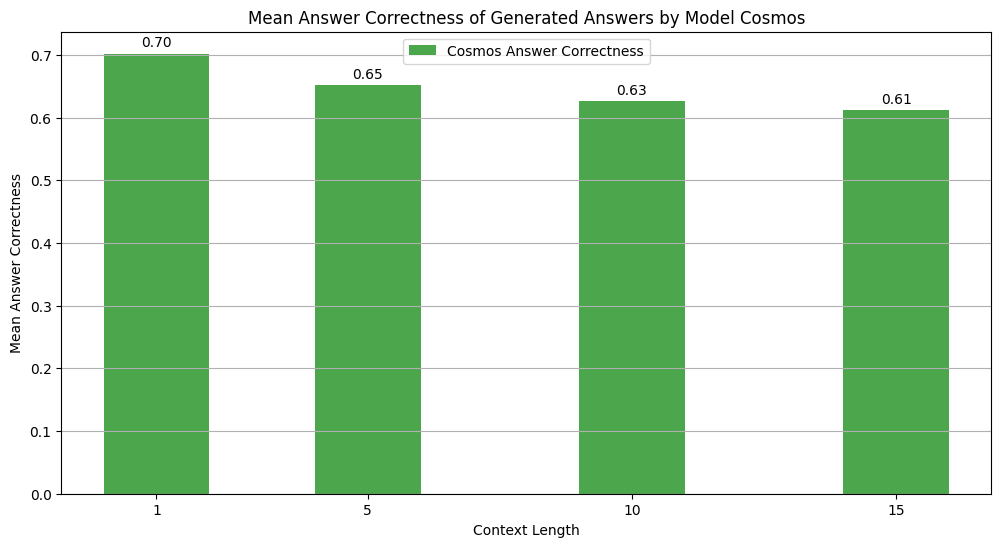

In [71]:
plot_answer_correctness_ragas_metric(cosmos_task_a_ragas_scores_file_names)

## Mean Answer Correctness Comparision Between Models (Cosmos vs Gemma)


In [72]:
# Plot the mean time for each context length
import matplotlib.pyplot as plt


def plot_answer_correctness_ragas_metric_cosmos_vs_gemma(file_names):

    model_name_for_plot = ''

    cosmos_mean_answer_correctness_array = []
    cosmos_context_len_array = []
    gemma_mean_answer_correctness_array = []
    gemma_context_len_array = []
    for file_name in file_names:
        # For compatibilty in local run
        file_name = os.path.splitext(os.path.basename(file_name))[0]
        df = pd.read_csv(RAGAS_SCORES_DIR + '/' + file_name + '.csv')

        logger.info(f"File: {file_name}")
        mean_answer_correctnes = df['answer_correctness'].astype(float).mean()
        context_len = df['number_of_articles'][0].astype(int)

        if 'cosmos' in file_name:
            model_name_for_plot = 'Cosmos'
            cosmos_mean_answer_correctness_array.append(mean_answer_correctnes)
            cosmos_context_len_array.append(context_len)
        elif 'gemma' in file_name:
            model_name_for_plot = 'Gemma'
            gemma_mean_answer_correctness_array.append(mean_answer_correctnes)
            gemma_context_len_array.append(context_len)

        logger.info(f"Mean faithfulness for generated answers by {model_name_for_plot} for context length {context_len}: " +
                    f"{mean_answer_correctnes:.2f}")
        logger.info("Shape of the dataframe: " + str(df.shape))
        print()

    plt.figure(figsize=(12, 6))

    plt.bar(cosmos_context_len_array, cosmos_mean_answer_correctness_array, width=2, alpha=0.7,
            label=f'Cosmos Answer Correctness', color='green', align='center')
    plt.bar(gemma_context_len_array, gemma_mean_answer_correctness_array, width=2, alpha=0.7,
            label=f'Gemma Answer Correctness', color='red', align='edge')

    # Add values on top of the bars
    for i in range(len(cosmos_context_len_array)):
        plt.text(cosmos_context_len_array[i], cosmos_mean_answer_correctness_array[i] +
                 0.011, f"{cosmos_mean_answer_correctness_array[i]:.2f}", ha='center')

    for i in range(len(gemma_context_len_array)):
        plt.text(gemma_context_len_array[i] + 1, gemma_mean_answer_correctness_array[i] +
                 0.011, f"{gemma_mean_answer_correctness_array[i]:.2f}", ha='center')

    # Set x-axis ticks to show all values
    plt.xticks(context_len_array)

    plt.xlabel('Context Length')
    plt.ylabel('Mean Answer Correctness')
    plt.title(f'Mean Answer Correctness of Generated Answers by Model Cosmos vs Gemma')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

[INFO] [2025-01-28T02:51:26.958Z] File:
    2025_01_26-16_41_10_cosmos_dpo_llm_answers_for_cntx_length_1_2025_01_27-22_09_45_ragas_scores

[INFO] [2025-01-28T02:51:26.959Z] Mean faithfulness for generated answers by Cosmos for context length 1: 0.70
[INFO] [2025-01-28T02:51:26.960Z] Shape of the dataframe: (100, 15)

[INFO] [2025-01-28T02:51:26.969Z] File:
    2025_01_26-16_50_39_cosmos_dpo_llm_answers_for_cntx_length_5_2025_01_27-22_43_31_ragas_scores

[INFO] [2025-01-28T02:51:26.969Z] Mean faithfulness for generated answers by Cosmos for context length 5: 0.65
[INFO] [2025-01-28T02:51:26.969Z] Shape of the dataframe: (100, 15)

[INFO] [2025-01-28T02:51:26.983Z] File:
    2025_01_26-17_02_32_cosmos_dpo_llm_answers_for_cntx_length_10_2025_01_27-23_14_49_ragas_scores

[INFO] [2025-01-28T02:51:26.983Z] Mean faithfulness for generated answers by Cosmos for context length 10: 0.63
[INFO] [2025-01-28T02:51:26.983Z] Shape of the dataframe: (100, 15)

[INFO] [2025-01-28T02:51:26.998Z] File:
 

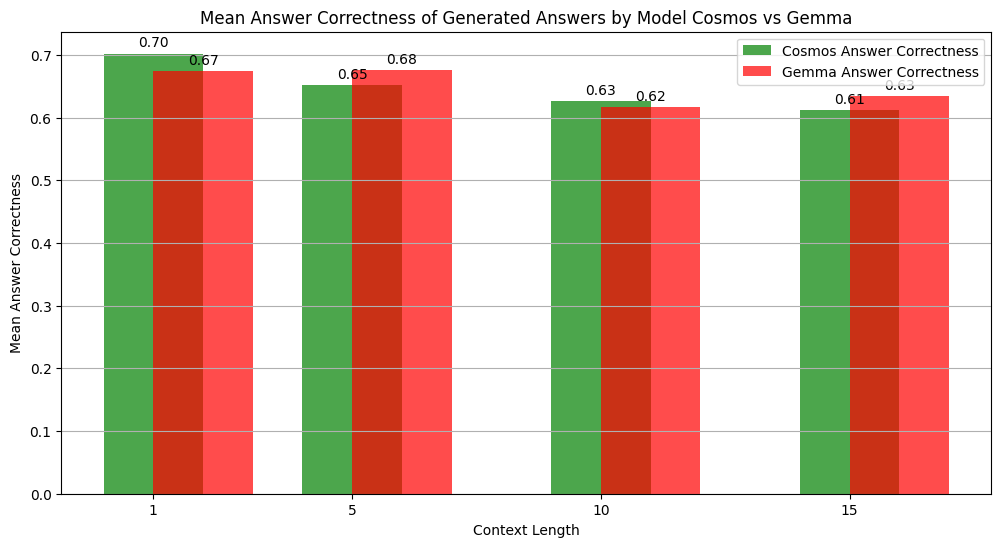

In [73]:
plot_answer_correctness_ragas_metric_cosmos_vs_gemma(cosmos_and_gemma_task_a_ragas_scores_file_names)

## Mean Answer Relevancy


In [81]:
# Plot the mean time for each context length
import matplotlib.pyplot as plt


def plot_answer_relevancy_ragas_metric(file_names):

    model_name_for_plot = ''
    context_len_array = []
    mean_answer_relevancy_array = []
    for file_name in file_names:
        # For compatibilty in local run
        file_name = os.path.splitext(os.path.basename(file_name))[0]
        df = pd.read_csv(RAGAS_SCORES_DIR + '/' + file_name + '.csv')

        if 'cosmos' in file_name:
            model_name_for_plot = 'Cosmos'
        elif 'gemma' in file_name:
            model_name_for_plot = 'Gemma'

        logger.info(f"File: {file_name}")

        context_len = df['number_of_articles'][0].astype(int)
        context_len_array.append(context_len)

        mean_answer_relevancy = df['answer_relevancy'].astype(float).mean()
        mean_answer_relevancy_array.append(mean_answer_relevancy)

        logger.info(f"Mean answer relevancy for generated answers by {model_name_for_plot} for context length {
                    context_len}: {mean_answer_relevancy:.2f}")
        logger.info("Shape of the dataframe: " + str(df.shape))
        print()

    plt.figure(figsize=(12, 6))
    plt.bar(context_len_array, mean_answer_relevancy_array, width=2, alpha=0.7,
            label=f'{model_name_for_plot} Answer Relevancy', color='green', align='center')

    # Add values on top of the bars
    for i in range(len(context_len_array)):
        plt.text(context_len_array[i], mean_answer_relevancy_array[i] + 0.011,
                 f"{mean_answer_relevancy_array[i]:.2f}", ha='center')

    # Set x-axis ticks to show all values
    plt.xticks(context_len_array)

    plt.xlabel('Context Length')
    plt.ylabel('Mean Answer Relevancy')
    plt.title(f'Mean Answer Relevancy of Generated Answers by Model {model_name_for_plot}')
    plt.legend(loc='center')
    plt.grid(axis='y')
    plt.show()

[INFO] [2025-01-28T02:58:09.584Z] File:
    2025_01_26-16_41_10_cosmos_dpo_llm_answers_for_cntx_length_1_2025_01_27-22_09_45_ragas_scores

[INFO] [2025-01-28T02:58:09.586Z] Mean answer relevancy for generated answers by Cosmos for context length 1: 0.86
[INFO] [2025-01-28T02:58:09.586Z] Shape of the dataframe: (100, 15)

[INFO] [2025-01-28T02:58:09.597Z] File:
    2025_01_26-16_50_39_cosmos_dpo_llm_answers_for_cntx_length_5_2025_01_27-22_43_31_ragas_scores

[INFO] [2025-01-28T02:58:09.598Z] Mean answer relevancy for generated answers by Cosmos for context length 5: 0.86
[INFO] [2025-01-28T02:58:09.598Z] Shape of the dataframe: (100, 15)

[INFO] [2025-01-28T02:58:09.612Z] File:
    2025_01_26-17_02_32_cosmos_dpo_llm_answers_for_cntx_length_10_2025_01_27-23_14_49_ragas_scores

[INFO] [2025-01-28T02:58:09.612Z] Mean answer relevancy for generated answers by Cosmos for context length 10: 0.84
[INFO] [2025-01-28T02:58:09.612Z] Shape of the dataframe: (100, 15)

[INFO] [2025-01-28T02:58:09.6

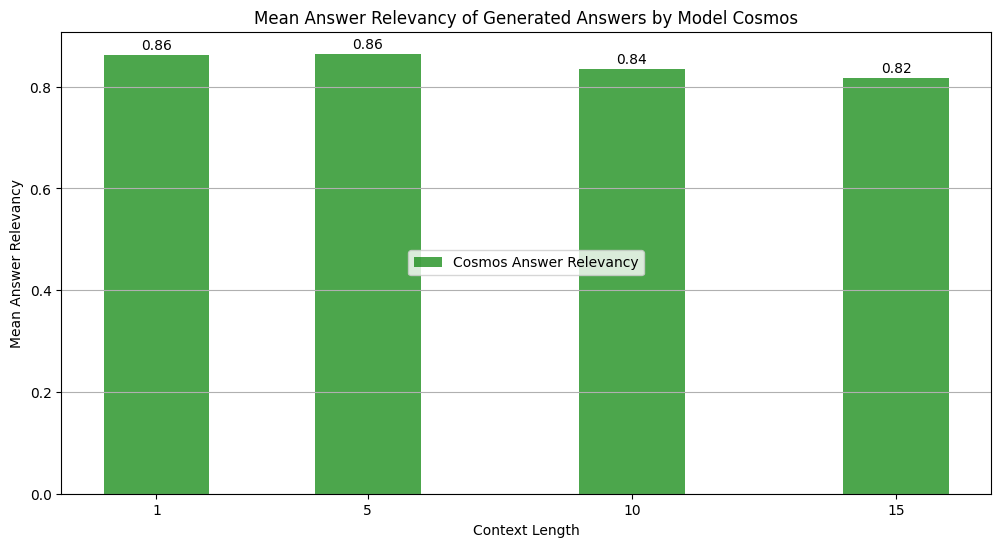

In [83]:
plot_answer_relevancy_ragas_metric(cosmos_task_a_ragas_scores_file_names)

## Mean Answer Relevancy Comparision Between Models (Cosmos vs Gemma)


In [86]:
# Plot the mean time for each context length
import matplotlib.pyplot as plt


def plot_answer_relevancy_ragas_metric_cosmos_vs_gemma(file_names):

    model_name_for_plot = ''

    cosmos_mean_answer_relevancy_array = []
    cosmos_context_len_array = []
    gemma_mean_answer_relevancy_array = []
    gemma_context_len_array = []
    for file_name in file_names:
        # For compatibilty in local run
        file_name = os.path.splitext(os.path.basename(file_name))[0]
        df = pd.read_csv(RAGAS_SCORES_DIR + '/' + file_name + '.csv')

        logger.info(f"File: {file_name}")
        mean_answer_relevancy = df['answer_relevancy'].astype(float).mean()
        context_len = df['number_of_articles'][0].astype(int)

        if 'cosmos' in file_name:
            model_name_for_plot = 'Cosmos'
            cosmos_mean_answer_relevancy_array.append(mean_answer_relevancy)
            cosmos_context_len_array.append(context_len)
        elif 'gemma' in file_name:
            model_name_for_plot = 'Gemma'
            gemma_mean_answer_relevancy_array.append(mean_answer_relevancy)
            gemma_context_len_array.append(context_len)

        logger.info(f"Mean faithfulness for generated answers by {model_name_for_plot} for context length {context_len}: " +
                    f"{mean_answer_relevancy:.2f}")
        logger.info("Shape of the dataframe: " + str(df.shape))
        print()

    plt.figure(figsize=(12, 6))

    plt.bar(cosmos_context_len_array, cosmos_mean_answer_relevancy_array, width=2, alpha=0.7,
            label=f'Cosmos Answer Relevancy', color='green', align='center')
    plt.bar(gemma_context_len_array, gemma_mean_answer_relevancy_array, width=2, alpha=0.7,
            label=f'Gemma Answer Relevancy', color='red', align='edge')

    # Add values on top of the bars
    for i in range(len(cosmos_context_len_array)):
        plt.text(cosmos_context_len_array[i], cosmos_mean_answer_relevancy_array[i] +
                 0.011, f"{cosmos_mean_answer_relevancy_array[i]:.2f}", ha='center')

    for i in range(len(gemma_context_len_array)):
        plt.text(gemma_context_len_array[i] + 1, gemma_mean_answer_relevancy_array[i] +
                 0.011, f"{gemma_mean_answer_relevancy_array[i]:.2f}", ha='center')

    # Set x-axis ticks to show all values
    plt.xticks(context_len_array)

    plt.xlabel('Context Length')
    plt.ylabel('Mean Answer Relevancy')
    plt.title(f'Mean Answer Relevancy of Generated Answers by Model Cosmos vs Gemma')
    plt.legend(loc='center')
    plt.grid(axis='y')
    plt.show()

[INFO] [2025-01-28T03:04:05.759Z] File:
    2025_01_26-16_41_10_cosmos_dpo_llm_answers_for_cntx_length_1_2025_01_27-22_09_45_ragas_scores

[INFO] [2025-01-28T03:04:05.760Z] Mean faithfulness for generated answers by Cosmos for context length 1: 0.86
[INFO] [2025-01-28T03:04:05.760Z] Shape of the dataframe: (100, 15)

[INFO] [2025-01-28T03:04:05.770Z] File:
    2025_01_26-16_50_39_cosmos_dpo_llm_answers_for_cntx_length_5_2025_01_27-22_43_31_ragas_scores

[INFO] [2025-01-28T03:04:05.771Z] Mean faithfulness for generated answers by Cosmos for context length 5: 0.86
[INFO] [2025-01-28T03:04:05.771Z] Shape of the dataframe: (100, 15)

[INFO] [2025-01-28T03:04:05.796Z] File:
    2025_01_26-17_02_32_cosmos_dpo_llm_answers_for_cntx_length_10_2025_01_27-23_14_49_ragas_scores

[INFO] [2025-01-28T03:04:05.798Z] Mean faithfulness for generated answers by Cosmos for context length 10: 0.84
[INFO] [2025-01-28T03:04:05.801Z] Shape of the dataframe: (100, 15)

[INFO] [2025-01-28T03:04:05.836Z] File:
 

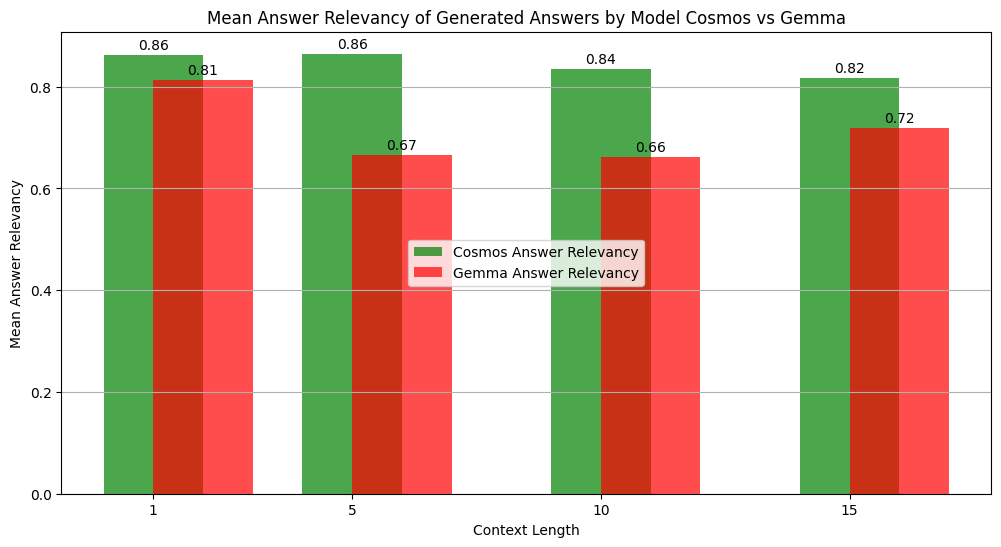

In [87]:
plot_answer_relevancy_ragas_metric_cosmos_vs_gemma(cosmos_and_gemma_task_a_ragas_scores_file_names)

# B) Correlation Between Context Position of Correct Answer and Answer Success

Doğru chunk ın 15 chunk tan oluşan context teki konumunun (1:8:15) llm cevaplama başarısına etkisi, En az 50 soru üzerinde RAGAS evaluation yap.


In [52]:
# TODO: This is used just for algorithm testing purposes. It should be updated to 50.
# NUM_OF_EVALUATED_QUESTIONS = 1
NUM_OF_EVALUATED_QUESTIONS = 50

# TODO: This is used just for algorithm testing purposes. It should be updated to [1, 8, 15]
# position_of_correct_answer_array = [3]
position_of_correct_answer_array = [1, 8, 15]

In [53]:
def save_llm_answers_for_context_position_of_correct_answer(results_df, model_name, position_of_correct_answer):
    # add time stamp to each file name for unique file names and further analysis
    time_stamp = time.strftime("%Y_%m_%d-%H_%M_%S")
    file_name = f'{LLM_ANSWERS_DIR}/{time_stamp}_{model_name}_llm_answers_for_cntx_length_15_' + \
        f'and_position_of_correct_answer_{position_of_correct_answer}.csv'

    results_df.to_csv(file_name, index=True)
    logger.info(f"Answers are saved to the file: '{file_name}'")
    return file_name


def get_llm_answers_for_context_position_of_correct_answer(model_name):
    file_names = []

    for position_of_correct_answer in position_of_correct_answer_array:

        prepared_context_data_df = prepare_new_context(
            selected_questions_df, NUM_OF_EVALUATED_QUESTIONS, 15, position_of_correct_answer - 1)

        prepared_context_data_df[f'{model_name}_answer'] = ""
        prepared_context_data_df['answer_generation_time'] = ""

        for i in range(NUM_OF_EVALUATED_QUESTIONS):
            chunk_unique_id = prepared_context_data_df.iloc[i]['id']
            index_of_chunk = prepared_context_data_df['id'] == chunk_unique_id

            question = get_question(prepared_context_data_df, chunk_unique_id)
            related_context = get_context(prepared_context_data_df, chunk_unique_id)

            start_time = time.time()
            generated_answer = ""
            if model_name == cosmos_model_name:
                generated_answer = generate_answer_for_cosmos_model(question, related_context)
            else:
                logger.error(f"Model name '{model_name}' is not supported!")
                assert False

            elapsed_time = time.time() - start_time
            elapsed_time = "{:.1f}".format(elapsed_time)  # shows as 1.3 s format
            logger.info("Elapsed time for answer generation to question " +
                        str(i + 1) + ": " + str(elapsed_time) + " seconds")

            prepared_context_data_df.loc[index_of_chunk, f'{model_name}_answer'] = generated_answer
            prepared_context_data_df.loc[index_of_chunk, 'answer_generation_time'] = elapsed_time

        # save result to a file
        file_name = save_llm_answers_for_context_position_of_correct_answer(
            prepared_context_data_df, model_name, position_of_correct_answer)
        file_names.append(file_name)

    return file_names

In [ ]:
file_names = get_llm_answers_for_context_position_of_correct_answer(cosmos_model_name)

In [ ]:
file_names

## Model Sonuçlarının Grafikleştirilmesi


In [88]:
# NOTE: Burada sadece google colab üzerinde çalıştırılan kodun çıktısı olan dosyalar kullanıldı.
#  Diğer eğitim süreleri çok uzun olduğu için buraya dahil edilmedi.
#  Aşağıda ragas evaluation yapılırkende bu dosyalar kullanılacak.

# TODO: Comment this lines if you want to see local run results
# Load the LLM answers from the file coming from google colab
task_b_file_names = [
    '2025_01_27-13_23_49_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_1.csv',
    '2025_01_27-13_27_58_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_8.csv',
    '2025_01_27-13_32_15_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_15.csv',
]

task_b_file_names

# print file names in llm_answer folder in python
# !ls -l {LLM_ANSWERS_DIR}

['2025_01_27-13_23_49_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_1.csv',
 '2025_01_27-13_27_58_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_8.csv',
 '2025_01_27-13_32_15_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_15.csv']

[INFO] [2025-01-28T03:17:03.135Z] File:
    2025_01_27-13_23_49_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_1.csv

[INFO] [2025-01-28T03:17:03.145Z] Mean time for generating answers by Cosmos for correct answer postion 1: 8.45 seconds
[INFO] [2025-01-28T03:17:03.146Z] Shape of the dataframe: (50, 11)

[INFO] [2025-01-28T03:17:03.146Z] File:
    2025_01_27-13_27_58_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_8.csv

[INFO] [2025-01-28T03:17:03.154Z] Mean time for generating answers by Cosmos for correct answer postion 8: 4.94 seconds
[INFO] [2025-01-28T03:17:03.154Z] Shape of the dataframe: (50, 11)

[INFO] [2025-01-28T03:17:03.154Z] File:
    2025_01_27-13_32_15_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_15.csv

[INFO] [2025-01-28T03:17:03.162Z] Mean time for generating answers by Cosmos for correct answer postion 15: 5.11 seconds
[INFO] [2025-01-28T03:17:03.163Z] Shape of the dataframe: (50, 11)



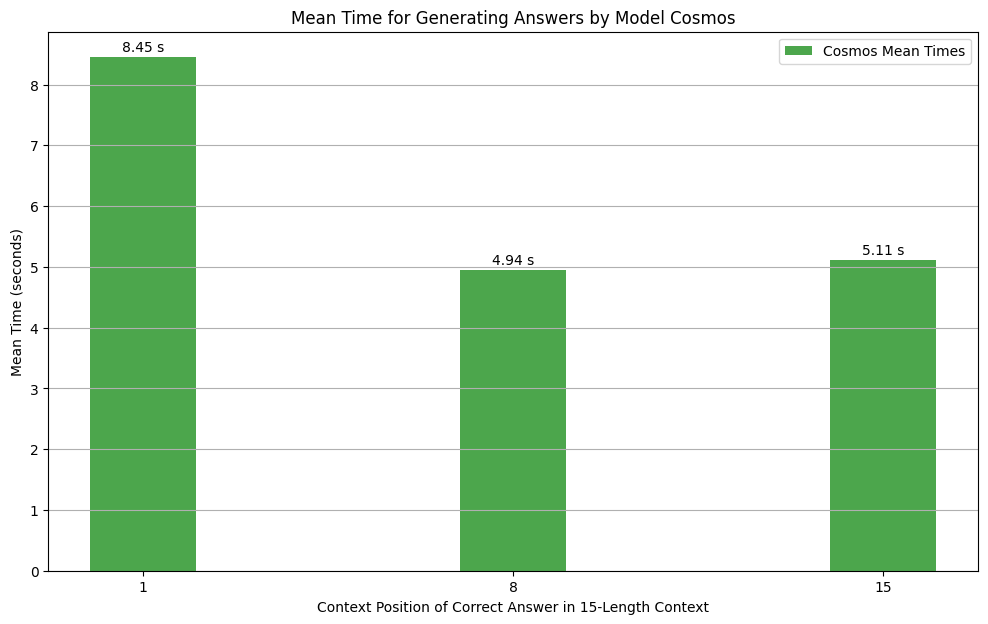

In [89]:
# Plot the mean time for each context position
import matplotlib.pyplot as plt

model_name_for_plot = ''
correct_answer_postion_array = []
mean_times_array = []
for file_name in task_b_file_names:
    logger.info(f"File: {file_name}")

    # For compatibilty in local run
    file_name = os.path.splitext(os.path.basename(file_name))[0]
    df = pd.read_csv(LLM_ANSWERS_DIR + '/' + file_name + '.csv')

    if 'cosmos' in file_name:
        model_name_for_plot = 'Cosmos'
    elif 'gemma' in file_name:
        model_name_for_plot = 'Gemma'

    correct_answer_postion = df['correct_intro_idx'][0].astype(int) + 1
    correct_answer_postion_array.append(correct_answer_postion)

    mean_times = df['answer_generation_time'].astype(float).mean()
    mean_times_array.append(mean_times)

    logger.info(f"Mean time for generating answers by {model_name_for_plot} for correct answer postion {
                correct_answer_postion}: {mean_times:.2f} seconds")
    logger.info("Shape of the dataframe: " + str(df.shape))
    print()


plt.figure(figsize=(12, 7))
plt.bar(correct_answer_postion_array, mean_times_array, width=2, alpha=0.7,
        label=f'{model_name_for_plot} Mean Times', color='green', align='center')

# Add seconds on top of the bars
for i in range(len(correct_answer_postion_array)):
    plt.text(correct_answer_postion_array[i], mean_times_array[i] + 0.1, f"{mean_times_array[i]:.2f} s", ha='center')

# Set x-axis ticks to show all values
plt.xticks(correct_answer_postion_array)

plt.xlabel('Context Position of Correct Answer in 15-Length Context')
plt.ylabel('Mean Time (seconds)')
plt.title(f'Mean Time for Generating Answers by Model {model_name_for_plot}')
plt.legend()
plt.grid(axis='y')
plt.show()

## RAGAS Evaluations


## Mean Faithfulness


In [3]:
cosmos_task_b_ragas_scores_file_names = [
    '2025_01_27-13_23_49_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_1_2025_01_28-01_10_30_ragas_scores.csv',
    '2025_01_27-13_27_58_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_8_2025_01_28-01_24_55_ragas_scores.csv',
    '2025_01_27-13_32_15_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_15_2025_01_28-01_39_24_ragas_scores.csv',
]

In [96]:
# Plot the mean time for each context length
import matplotlib.pyplot as plt


def plot_faithfulness_ragas_metric_for_task_b(file_names):

    model_name_for_plot = ''
    correct_answer_postion_array = []
    mean_faithfulness_array = []
    for file_name in file_names:
        # For compatibilty in local run
        file_name = os.path.splitext(os.path.basename(file_name))[0]
        df = pd.read_csv(RAGAS_SCORES_DIR + '/' + file_name + '.csv')

        if 'cosmos' in file_name:
            model_name_for_plot = 'Cosmos'
        elif 'gemma' in file_name:
            model_name_for_plot = 'Gemma'

        logger.info(f"File: {file_name}")

        correct_answer_postion = df['correct_intro_idx'][0].astype(int) + 1
        correct_answer_postion_array.append(correct_answer_postion)

        mean_faithfulness = df['faithfulness'].astype(float).mean()
        mean_faithfulness_array.append(mean_faithfulness)

        logger.info(f"Mean faithfulness for generated answers by {model_name_for_plot} for correct answer postion {
            correct_answer_postion}: {mean_faithfulness:.2f}")
        logger.info("Shape of the dataframe: " + str(df.shape))
        print()

    plt.figure(figsize=(12, 6))
    plt.bar(correct_answer_postion_array, mean_faithfulness_array, width=2, alpha=0.7,
            label=f'{model_name_for_plot} Mean Faithfulness', color='green', align='center')

    # Add values on top of the bars
    for i in range(len(correct_answer_postion_array)):
        plt.text(correct_answer_postion_array[i], mean_faithfulness_array[i] + 0.011,
                 f"{mean_faithfulness_array[i]:.2f}", ha='center')

    # Set x-axis ticks to show all values
    plt.xticks(correct_answer_postion_array)

    plt.xlabel('Context Position of Correct Answer in 15-Length Context')
    plt.ylabel('Mean Faithfulness')
    plt.title(f'Mean Faithfulness of Generated Answers by Model {model_name_for_plot}')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

[INFO] [2025-01-28T03:33:45.408Z] File: 2025_01_27-
    13_23_49_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_1_2025_01_28-01_10_30_ragas_scores

[INFO] [2025-01-28T03:33:45.409Z] Mean faithfulness for generated answers by Cosmos for correct answer postion 1: 0.79
[INFO] [2025-01-28T03:33:45.409Z] Shape of the dataframe: (50, 15)



[INFO] [2025-01-28T03:33:45.419Z] File: 2025_01_27-
    13_27_58_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_8_2025_01_28-01_24_55_ragas_scores

[INFO] [2025-01-28T03:33:45.419Z] Mean faithfulness for generated answers by Cosmos for correct answer postion 8: 0.85
[INFO] [2025-01-28T03:33:45.419Z] Shape of the dataframe: (50, 15)

[INFO] [2025-01-28T03:33:45.429Z] File: 2025_01_27-
    13_32_15_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_15_2025_01_28-01_39_24_ragas_scores

[INFO] [2025-01-28T03:33:45.430Z] Mean faithfulness for generated answers by Cosmos for correct answer postion 15: 0.76
[INFO] [2025-01-28T03:33:45.430Z] Shape of the dataframe: (50, 15)



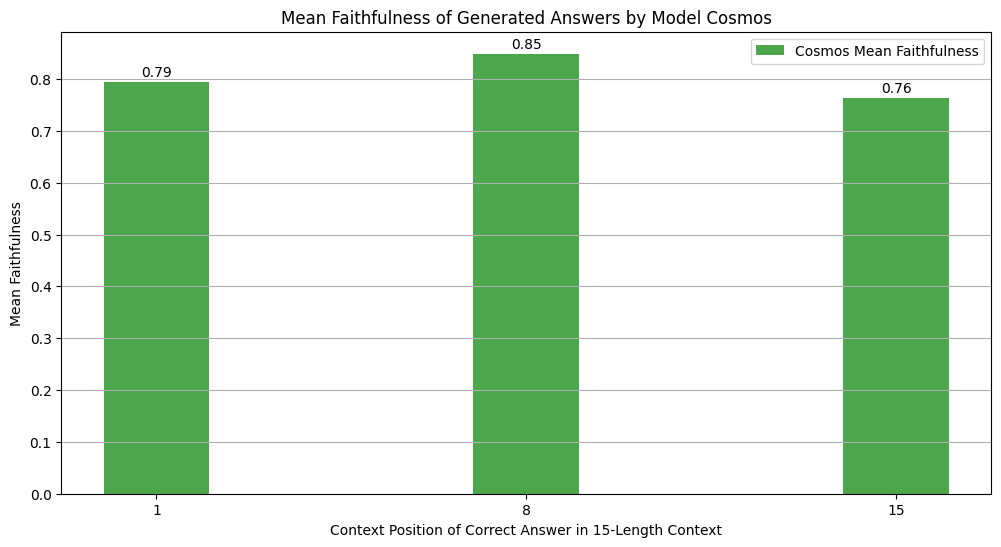

In [97]:
plot_faithfulness_ragas_metric_for_task_b(cosmos_task_b_ragas_scores_file_names)

## Mean Faithfulness Comparision Between Models (Cosmos vs Gemma)


In [19]:
# NOTE: Burada sadece google colab üzerinde çalıştırılan kodun çıktısı olan dosyalar kullanıldı.

cosmos_and_gemma_task_b_ragas_scores_file_names = [
    # cosmos model
    '2025_01_27-13_23_49_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_1_2025_01_28-01_10_30_ragas_scores.csv',
    '2025_01_27-13_27_58_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_8_2025_01_28-01_24_55_ragas_scores.csv',
    '2025_01_27-13_32_15_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_15_2025_01_28-01_39_24_ragas_scores.csv',
    # gemma model
    '2025_01_27-12_40_21_gemma_2_9b_llm_answers_for_cntx_length_15_and_position_of_correct_answer_1_2025_01_27-23_19_33_ragas_scores.csv',
    '2025_01_27-13_00_31_gemma_2_9b_llm_answers_for_cntx_length_15_and_position_of_correct_answer_8_2025_01_27-23_41_15_ragas_scores.csv',
    '2025_01_27-13_20_42_gemma_2_9b_llm_answers_for_cntx_length_15_and_position_of_correct_answer_15_2025_01_27-23_58_25_ragas_scores.csv',
]

In [106]:
# Plot the mean time for each context length
import matplotlib.pyplot as plt


def plot_faithfulness_ragas_metric_cosmos_vs_gemma_task_b(file_names):

    model_name_for_plot = ''

    cosmos_mean_faithfulness_array = []
    cosmos_correct_answer_postion_array = []
    gemma_mean_faithfulness_array = []
    gemma_correct_answer_postion_array = []
    for file_name in file_names:
        # For compatibilty in local run
        file_name = os.path.splitext(os.path.basename(file_name))[0]
        df = pd.read_csv(RAGAS_SCORES_DIR + '/' + file_name + '.csv')

        logger.info(f"File: {file_name}")
        mean_faithfulness = df['faithfulness'].astype(float).mean()
        correct_answer_postion = df['correct_intro_idx'][0].astype(int) + 1

        if 'cosmos' in file_name:
            model_name_for_plot = 'Cosmos'
            cosmos_mean_faithfulness_array.append(mean_faithfulness)
            cosmos_correct_answer_postion_array.append(correct_answer_postion)
        elif 'gemma' in file_name:
            model_name_for_plot = 'Gemma'
            gemma_mean_faithfulness_array.append(mean_faithfulness)
            gemma_correct_answer_postion_array.append(correct_answer_postion)

        logger.info(f"Mean faithfulness for generated answers by {model_name_for_plot} for correct answer postion {
            correct_answer_postion}: " +
            f"{mean_faithfulness:.2f}")
        logger.info("Shape of the dataframe: " + str(df.shape))
        print()

    plt.figure(figsize=(12, 6))

    plt.bar(cosmos_correct_answer_postion_array, cosmos_mean_faithfulness_array, width=2, alpha=0.7,
            label=f'Cosmos Mean Faithfulness', color='green', align='center')
    plt.bar(gemma_correct_answer_postion_array, gemma_mean_faithfulness_array, width=2, alpha=0.7,
            label=f'Gemma Mean Faithfulness', color='red', align='edge')

    # Add values on top of the bars
    for i in range(len(cosmos_correct_answer_postion_array)):
        plt.text(cosmos_correct_answer_postion_array[i], cosmos_mean_faithfulness_array[i] +
                 0.011, f"{cosmos_mean_faithfulness_array[i]:.2f}", ha='center')

    for i in range(len(gemma_correct_answer_postion_array)):
        plt.text(gemma_correct_answer_postion_array[i] + 1, gemma_mean_faithfulness_array[i] +
                 0.011, f"{gemma_mean_faithfulness_array[i]:.2f}", ha='center')

    # Set x-axis ticks to show all values
    plt.xticks(cosmos_correct_answer_postion_array)

    plt.xlabel('Context Position of Correct Answer in 15-Length Context')
    plt.ylabel('Mean Faithfulness')
    plt.title(f'Mean Faithfulness of Generated Answers by Model Cosmos vs Gemma')
    plt.legend(loc='center')
    plt.grid(axis='y')
    plt.show()

[INFO] [2025-01-28T09:24:45.801Z] File: 2025_01_27-
    13_23_49_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_1_2025_01_28-01_10_30_ragas_scores

[INFO] [2025-01-28T09:24:45.802Z] Mean faithfulness for generated answers by Cosmos for correct answer postion 1: 0.79
[INFO] [2025-01-28T09:24:45.802Z] Shape of the dataframe: (50, 15)

[INFO] [2025-01-28T09:24:45.812Z] File: 2025_01_27-
    13_27_58_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_8_2025_01_28-01_24_55_ragas_scores

[INFO] [2025-01-28T09:24:45.813Z] Mean faithfulness for generated answers by Cosmos for correct answer postion 8: 0.85
[INFO] [2025-01-28T09:24:45.813Z] Shape of the dataframe: (50, 15)

[INFO] [2025-01-28T09:24:45.823Z] File: 2025_01_27-
    13_32_15_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_15_2025_01_28-01_39_24_ragas_scores

[INFO] [2025-01-28T09:24:45.823Z] Mean faithfulness for generated answers by Cosmos for correct answer 

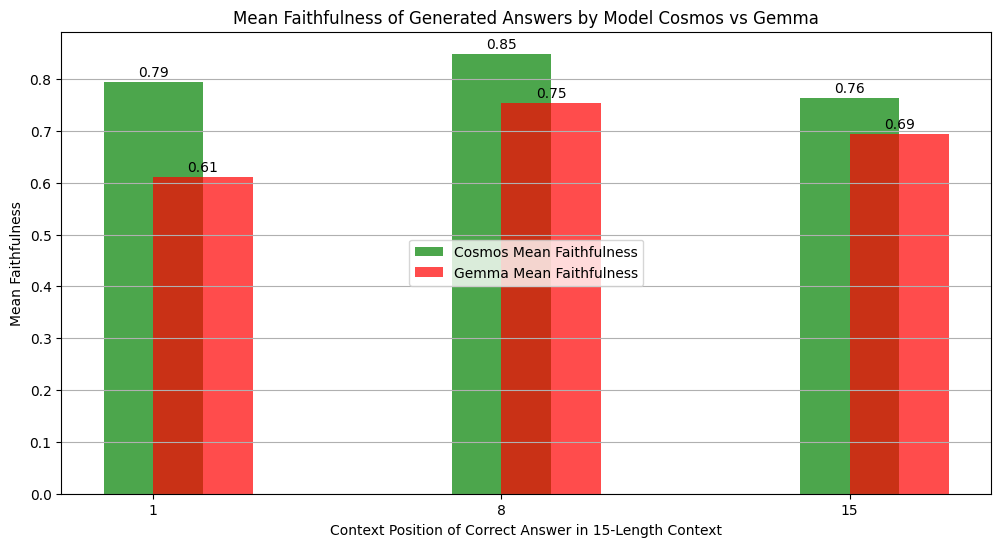

In [107]:
plot_faithfulness_ragas_metric_cosmos_vs_gemma_task_b(cosmos_and_gemma_task_b_ragas_scores_file_names)

# Answer Correctness


In [17]:
# Plot the mean time for each context length
import matplotlib.pyplot as plt
import os
import pandas as pd


def plot_answer_correctness_ragas_metric_for_task_b(file_names):

    model_name_for_plot = ''
    correct_answer_postion_array = []
    mean_answer_correctness_array = []
    for file_name in file_names:
        # For compatibilty in local run
        file_name = os.path.splitext(os.path.basename(file_name))[0]
        df = pd.read_csv(RAGAS_SCORES_DIR + '/' + file_name + '.csv')

        if 'cosmos' in file_name:
            model_name_for_plot = 'Cosmos'
        elif 'gemma' in file_name:
            model_name_for_plot = 'Gemma'

        logger.info(f"File: {file_name}")

        correct_answer_postion = df['correct_intro_idx'][0].astype(int) + 1
        correct_answer_postion_array.append(correct_answer_postion)

        mean_answer_correctness = df['answer_correctness'].astype(float).mean()
        mean_answer_correctness_array.append(mean_answer_correctness)

        logger.info(f"Mean answer correctness for generated answers by {model_name_for_plot} for correct answer postion {
            correct_answer_postion}: {mean_answer_correctness:.2f}")
        logger.info("Shape of the dataframe: " + str(df.shape))
        print()

    plt.figure(figsize=(12, 6))
    plt.bar(correct_answer_postion_array, mean_answer_correctness_array, width=2, alpha=0.7,
            label=f'{model_name_for_plot} Mean Answer Correctness', color='green', align='center')

    # Add values on top of the bars
    for i in range(len(correct_answer_postion_array)):
        plt.text(correct_answer_postion_array[i], mean_answer_correctness_array[i] + 0.011,
                 f"{mean_answer_correctness_array[i]:.2f}", ha='center')

    # Set x-axis ticks to show all values
    plt.xticks(correct_answer_postion_array)

    plt.xlabel('Context Position of Correct Answer in 15-Length Context')
    plt.ylabel('Mean Answer Correctness')
    plt.title(f'Mean Answer Correctness of Generated Answers by Model {model_name_for_plot}')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

[INFO] [2025-01-28T09:33:40.661Z] File: 2025_01_27-
    13_23_49_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_1_2025_01_28-01_10_30_ragas_scores

[INFO] [2025-01-28T09:33:40.662Z] Mean answer correctness for generated answers by Cosmos for correct answer postion 1:
    0.48

[INFO] [2025-01-28T09:33:40.662Z] Shape of the dataframe: (50, 15)

[INFO] [2025-01-28T09:33:40.678Z] File: 2025_01_27-
    13_27_58_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_8_2025_01_28-01_24_55_ragas_scores

[INFO] [2025-01-28T09:33:40.679Z] Mean answer correctness for generated answers by Cosmos for correct answer postion 8:
    0.61

[INFO] [2025-01-28T09:33:40.680Z] Shape of the dataframe: (50, 15)

[INFO] [2025-01-28T09:33:40.695Z] File: 2025_01_27-
    13_32_15_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_15_2025_01_28-01_39_24_ragas_scores

[INFO] [2025-01-28T09:33:40.696Z] Mean answer correctness for generated answers b

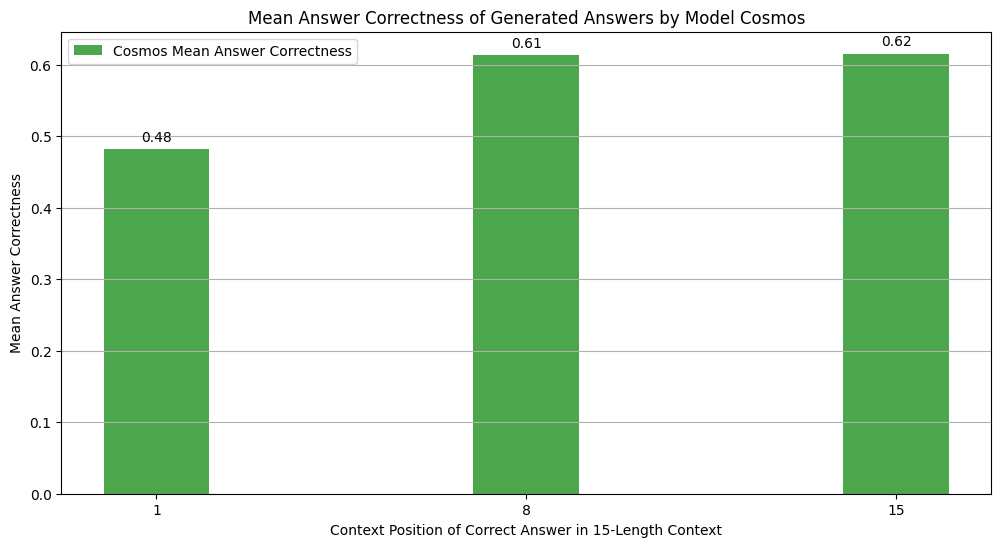

In [18]:
plot_answer_correctness_ragas_metric_for_task_b(cosmos_task_b_ragas_scores_file_names)

## Mean Answer Correctness Comparision Between Models (Cosmos vs Gemma)


In [24]:
# Plot the mean time for each context length
import matplotlib.pyplot as plt


def plot_answer_correctness_ragas_metric_cosmos_vs_gemma_task_b(file_names):

    model_name_for_plot = ''

    cosmos_mean_mean_answer_correctness_array = []
    cosmos_correct_answer_postion_array = []
    gemma_mean_answer_correctness_array = []
    gemma_correct_answer_postion_array = []
    for file_name in file_names:
        # For compatibilty in local run
        file_name = os.path.splitext(os.path.basename(file_name))[0]
        df = pd.read_csv(RAGAS_SCORES_DIR + '/' + file_name + '.csv')

        logger.info(f"File: {file_name}")
        mean_answer_correctness = df['answer_correctness'].astype(float).mean()
        correct_answer_postion = df['correct_intro_idx'][0].astype(int) + 1

        if 'cosmos' in file_name:
            model_name_for_plot = 'Cosmos'
            cosmos_mean_mean_answer_correctness_array.append(mean_answer_correctness)
            cosmos_correct_answer_postion_array.append(correct_answer_postion)
        elif 'gemma' in file_name:
            model_name_for_plot = 'Gemma'
            gemma_mean_answer_correctness_array.append(mean_answer_correctness)
            gemma_correct_answer_postion_array.append(correct_answer_postion)

        logger.info(f"Mean answer correctness for generated answers by {model_name_for_plot} for correct answer postion {
            correct_answer_postion}: " +
            f"{mean_answer_correctness:.2f}")
        logger.info("Shape of the dataframe: " + str(df.shape))
        print()

    plt.figure(figsize=(12, 6))

    plt.bar(cosmos_correct_answer_postion_array, cosmos_mean_mean_answer_correctness_array, width=2, alpha=0.7,
            label=f'Cosmos Mean Answer Correctness', color='green', align='center')
    plt.bar(gemma_correct_answer_postion_array, gemma_mean_answer_correctness_array, width=2, alpha=0.7,
            label=f'Gemma Mean Answer Correctness', color='red', align='edge')

    # Add values on top of the bars
    for i in range(len(cosmos_correct_answer_postion_array)):
        plt.text(cosmos_correct_answer_postion_array[i], cosmos_mean_mean_answer_correctness_array[i] +
                 0.011, f"{cosmos_mean_mean_answer_correctness_array[i]:.2f}", ha='center')

    for i in range(len(gemma_correct_answer_postion_array)):
        plt.text(gemma_correct_answer_postion_array[i] + 1, gemma_mean_answer_correctness_array[i] +
                 0.011, f"{gemma_mean_answer_correctness_array[i]:.2f}", ha='center')

    # Set x-axis ticks to show all values
    plt.xticks(cosmos_correct_answer_postion_array)

    plt.xlabel('Context Position of Correct Answer in 15-Length Context')
    plt.ylabel('Mean Answer Correctness')
    plt.title(f'Mean Answer Correctness of Generated Answers by Model Cosmos vs Gemma')
    plt.legend(loc='center')
    plt.grid(axis='y')
    plt.show()

[INFO] [2025-01-28T09:41:47.160Z] File: 2025_01_27-
    13_23_49_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_1_2025_01_28-01_10_30_ragas_scores

[INFO] [2025-01-28T09:41:47.161Z] Mean answer correctness for generated answers by Cosmos for correct answer postion 1:
    0.48

[INFO] [2025-01-28T09:41:47.161Z] Shape of the dataframe: (50, 15)

[INFO] [2025-01-28T09:41:47.173Z] File: 2025_01_27-
    13_27_58_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_8_2025_01_28-01_24_55_ragas_scores

[INFO] [2025-01-28T09:41:47.173Z] Mean answer correctness for generated answers by Cosmos for correct answer postion 8:
    0.61

[INFO] [2025-01-28T09:41:47.174Z] Shape of the dataframe: (50, 15)

[INFO] [2025-01-28T09:41:47.184Z] File: 2025_01_27-
    13_32_15_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_15_2025_01_28-01_39_24_ragas_scores

[INFO] [2025-01-28T09:41:47.185Z] Mean answer correctness for generated answers b

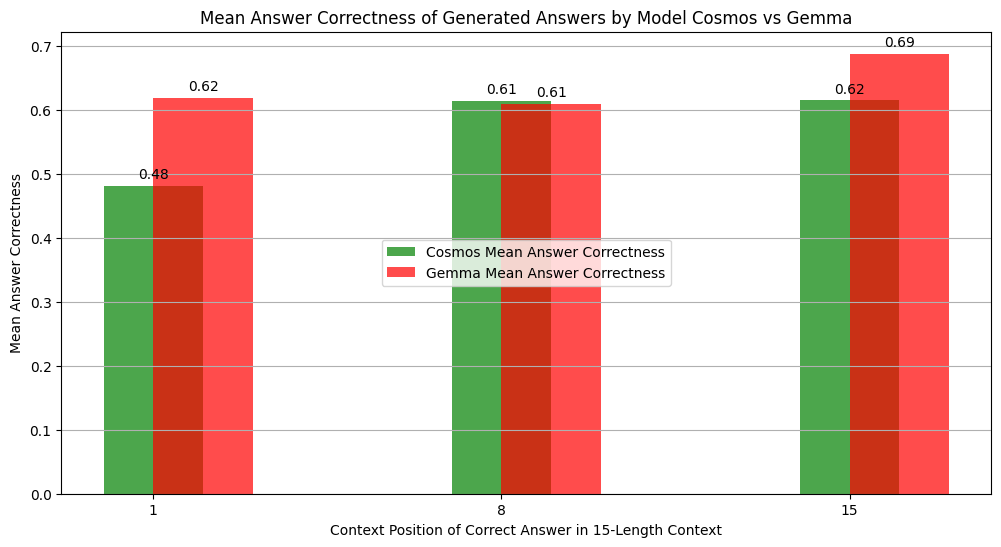

In [25]:
plot_answer_correctness_ragas_metric_cosmos_vs_gemma_task_b(cosmos_and_gemma_task_b_ragas_scores_file_names)

# Answer Relevancy


In [28]:
# Plot the mean time for each context length
import matplotlib.pyplot as plt
import os
import pandas as pd


def plot_answer_relevancy_ragas_metric_for_task_b(file_names):

    model_name_for_plot = ''
    correct_answer_postion_array = []
    mean_answer_relevancy_array = []
    for file_name in file_names:
        # For compatibilty in local run
        file_name = os.path.splitext(os.path.basename(file_name))[0]
        df = pd.read_csv(RAGAS_SCORES_DIR + '/' + file_name + '.csv')

        if 'cosmos' in file_name:
            model_name_for_plot = 'Cosmos'
        elif 'gemma' in file_name:
            model_name_for_plot = 'Gemma'

        logger.info(f"File: {file_name}")

        correct_answer_postion = df['correct_intro_idx'][0].astype(int) + 1
        correct_answer_postion_array.append(correct_answer_postion)

        mean_answer_relevancy = df['answer_relevancy'].astype(float).mean()
        mean_answer_relevancy_array.append(mean_answer_relevancy)

        logger.info(f"Mean answer relevancy for generated answers by {model_name_for_plot} for correct answer postion {
            correct_answer_postion}: {mean_answer_relevancy:.2f}")
        logger.info("Shape of the dataframe: " + str(df.shape))
        print()

    plt.figure(figsize=(12, 6))
    plt.bar(correct_answer_postion_array, mean_answer_relevancy_array, width=2, alpha=0.7,
            label=f'{model_name_for_plot} Mean Answer Relevancy', color='green', align='center')

    # Add values on top of the bars
    for i in range(len(correct_answer_postion_array)):
        plt.text(correct_answer_postion_array[i], mean_answer_relevancy_array[i] + 0.011,
                 f"{mean_answer_relevancy_array[i]:.2f}", ha='center')

    # Set x-axis ticks to show all values
    plt.xticks(correct_answer_postion_array)

    plt.xlabel('Context Position of Correct Answer in 15-Length Context')
    plt.ylabel('Mean Answer Relevancy')
    plt.title(f'Mean Answer Relevancy of Generated Answers by Model {model_name_for_plot}')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

[INFO] [2025-01-28T09:53:18.536Z] File: 2025_01_27-
    13_23_49_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_1_2025_01_28-01_10_30_ragas_scores

[INFO] [2025-01-28T09:53:18.538Z] Mean answer relevancy for generated answers by Cosmos for correct answer postion 1:
    0.66

[INFO] [2025-01-28T09:53:18.539Z] Shape of the dataframe: (50, 15)

[INFO] [2025-01-28T09:53:18.553Z] File: 2025_01_27-
    13_27_58_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_8_2025_01_28-01_24_55_ragas_scores

[INFO] [2025-01-28T09:53:18.555Z] Mean answer relevancy for generated answers by Cosmos for correct answer postion 8:
    0.82

[INFO] [2025-01-28T09:53:18.555Z] Shape of the dataframe: (50, 15)

[INFO] [2025-01-28T09:53:18.565Z] File: 2025_01_27-
    13_32_15_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_15_2025_01_28-01_39_24_ragas_scores

[INFO] [2025-01-28T09:53:18.566Z] Mean answer relevancy for generated answers by Cosm

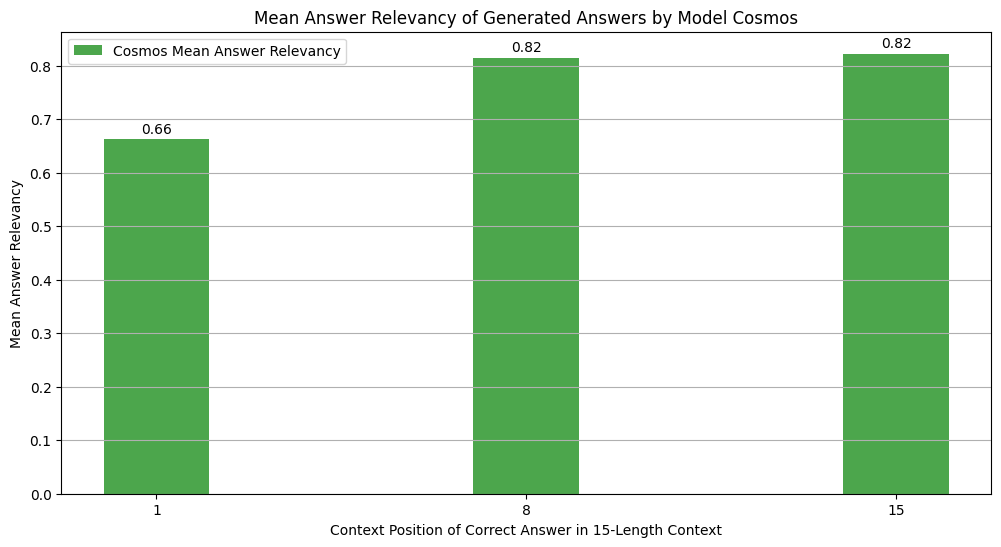

In [29]:
plot_answer_relevancy_ragas_metric_for_task_b(cosmos_task_b_ragas_scores_file_names)

## Mean Answer Relevancy Comparision Between Models (Cosmos vs Gemma)


In [33]:
# Plot the mean time for each context length
import matplotlib.pyplot as plt


def plot_answer_relevancy_ragas_metric_cosmos_vs_gemma_task_b(file_names):

    model_name_for_plot = ''

    cosmos_mean_answer_relevancy_array = []
    cosmos_correct_answer_postion_array = []
    gemma_mean_answer_relevancy_array = []
    gemma_correct_answer_postion_array = []
    for file_name in file_names:
        # For compatibilty in local run
        file_name = os.path.splitext(os.path.basename(file_name))[0]
        df = pd.read_csv(RAGAS_SCORES_DIR + '/' + file_name + '.csv')

        logger.info(f"File: {file_name}")
        mean_answer_relevancy = df['answer_relevancy'].astype(float).mean()
        correct_answer_postion = df['correct_intro_idx'][0].astype(int) + 1

        if 'cosmos' in file_name:
            model_name_for_plot = 'Cosmos'
            cosmos_mean_answer_relevancy_array.append(mean_answer_relevancy)
            cosmos_correct_answer_postion_array.append(correct_answer_postion)
        elif 'gemma' in file_name:
            model_name_for_plot = 'Gemma'
            gemma_mean_answer_relevancy_array.append(mean_answer_relevancy)
            gemma_correct_answer_postion_array.append(correct_answer_postion)

        logger.info(f"Mean answer relevancy for generated answers by {model_name_for_plot} for correct answer postion {
            correct_answer_postion}: " +
            f"{mean_answer_relevancy:.2f}")
        logger.info("Shape of the dataframe: " + str(df.shape))
        print()

    plt.figure(figsize=(12, 6))

    plt.bar(cosmos_correct_answer_postion_array, cosmos_mean_answer_relevancy_array, width=2, alpha=0.7,
            label=f'Cosmos Mean Answer Relevancy', color='green', align='center')
    plt.bar(gemma_correct_answer_postion_array, gemma_mean_answer_relevancy_array, width=2, alpha=0.7,
            label=f'Gemma Mean Answer Relevancy', color='red', align='edge')

    # Add values on top of the bars
    for i in range(len(cosmos_correct_answer_postion_array)):
        plt.text(cosmos_correct_answer_postion_array[i], cosmos_mean_answer_relevancy_array[i] +
                 0.011, f"{cosmos_mean_answer_relevancy_array[i]:.2f}", ha='center')

    for i in range(len(gemma_correct_answer_postion_array)):
        plt.text(gemma_correct_answer_postion_array[i] + 1, gemma_mean_answer_relevancy_array[i] +
                 0.011, f"{gemma_mean_answer_relevancy_array[i]:.2f}", ha='center')

    # Set x-axis ticks to show all values
    plt.xticks(cosmos_correct_answer_postion_array)

    plt.xlabel('Context Position of Correct Answer in 15-Length Context')
    plt.ylabel('Mean Answer Relevancy')
    plt.title(f'Mean Answer Relevancy of Generated Answers by Model Cosmos vs Gemma')
    plt.legend(loc='center')
    plt.grid(axis='y')
    plt.show()

[INFO] [2025-01-28T10:00:54.912Z] File: 2025_01_27-
    13_23_49_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_1_2025_01_28-01_10_30_ragas_scores



[INFO] [2025-01-28T10:00:54.913Z] Mean answer relevancy for generated answers by Cosmos for correct answer postion 1:
    0.66

[INFO] [2025-01-28T10:00:54.914Z] Shape of the dataframe: (50, 15)

[INFO] [2025-01-28T10:00:54.926Z] File: 2025_01_27-
    13_27_58_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_8_2025_01_28-01_24_55_ragas_scores

[INFO] [2025-01-28T10:00:54.927Z] Mean answer relevancy for generated answers by Cosmos for correct answer postion 8:
    0.82

[INFO] [2025-01-28T10:00:54.927Z] Shape of the dataframe: (50, 15)

[INFO] [2025-01-28T10:00:54.938Z] File: 2025_01_27-
    13_32_15_cosmos_dpo_llm_answers_for_cntx_length_15_and_position_of_correct_answer_15_2025_01_28-01_39_24_ragas_scores

[INFO] [2025-01-28T10:00:54.938Z] Mean answer relevancy for generated answers by Cosmos for correct answer postion 15:
    0.82

[INFO] [2025-01-28T10:00:54.938Z] Shape of the dataframe: (50, 15)

[INFO] [2025-01-28T10:00:54.948Z] File: 2025_01_27-
    12_40_

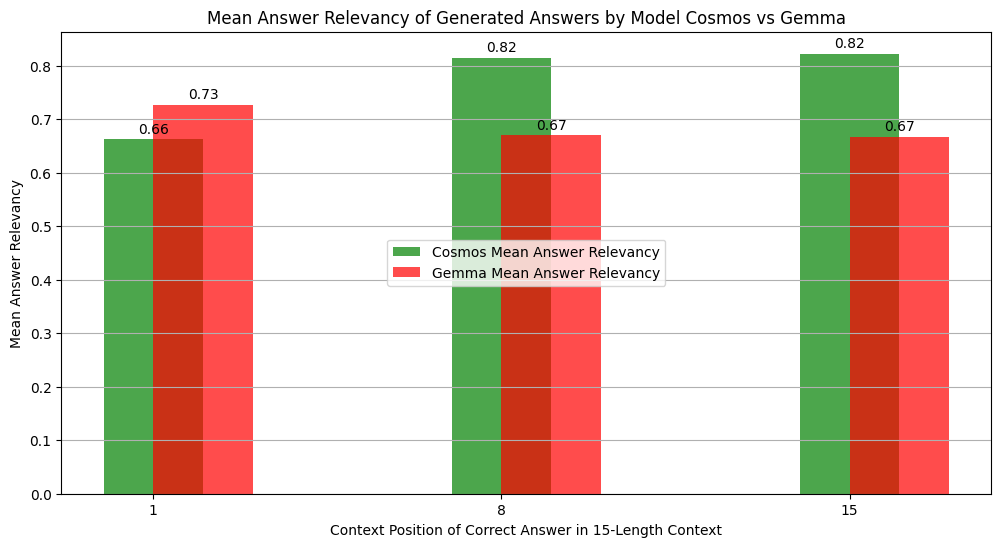

In [34]:
plot_answer_relevancy_ragas_metric_cosmos_vs_gemma_task_b(cosmos_and_gemma_task_b_ragas_scores_file_names)

# Referanslar

- [Used Dataset: Metin/WikiRAG-TR](https://huggingface.co/datasets/Metin/WikiRAG-TR)
- [Used Model: ytu-ce-cosmos/Turkish-Llama-8b-DPO-v0.1](https://huggingface.co/ytu-ce-cosmos/Turkish-Llama-8b-DPO-v0.1)
- [x] [Overview of Metrics](https://docs.ragas.io/en/latest/concepts/metrics/overview/)
- [x] [List of available metrics](https://docs.ragas.io/en/latest/concepts/metrics/available_metrics/)
  - Retrieval Augmented Generation Metrics
    - [x] [Context Precision](https://docs.ragas.io/en/latest/concepts/metrics/available_metrics/context_precision/)
    - [x] [Context Recall](https://docs.ragas.io/en/latest/concepts/metrics/available_metrics/context_recall/)
    - [x] [Context Entities Recall](https://docs.ragas.io/en/latest/concepts/metrics/available_metrics/context_entities_recall/)
    - [x] [Noise Sensitivity](https://docs.ragas.io/en/latest/concepts/metrics/available_metrics/noise_sensitivity/)
    - [x] [Response Relevancy or Answer Relevancy](https://docs.ragas.io/en/latest/concepts/metrics/available_metrics/answer_relevance/)
    - [x] [Faithfulness](https://docs.ragas.io/en/latest/concepts/metrics/available_metrics/faithfulness/)
    - [x] [Multi modal faithfulness](https://docs.ragas.io/en/latest/concepts/metrics/available_metrics/multi_modal_faithfulness/)
    - [x] [Multi modal relevance](https://docs.ragas.io/en/latest/concepts/metrics/available_metrics/multi_modal_relevance/)
  - RAGAS ile alakalı olmayan diğerlerine de bakılması faydalı olabilir. Proje kapsamında ben sadece RAGAS ile alakalı olanları inceledim.
- [x] [github -> amazon-science -> RAGChecker](https://github.com/amazon-science/RAGChecker/tree/main)
- [x] [RAGAS: How to Evaluate a RAG Application Like a Pro for Beginners](https://www.youtube.com/watch?v=5fp6e5nhJRk)
- [x] [Chat Templates](https://huggingface.co/docs/transformers/main/en/chat_templating)
  - [ ] TODO: Advanced: Tool use / function calling başlığında kaldım.
